<a href="https://colab.research.google.com/github/Benjabby/CE888-Resit/blob/master/CE888_Resit_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
%%capture
!pip install modAL
!pip install umap-learn[plot]
import os
from os import path
import modAL as al
from modAL import batch as alb
import sklearn as sk
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression, PassiveAggressiveClassifier, Perceptron
from sklearn.decomposition import PCA, IncrementalPCA, FastICA
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.dummy import DummyClassifier
from scipy import interp
import lzma
#from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
import seaborn as sns
import pickle as pk
import gc
import umap
#import umap.plot as up
SEED = 0xDDDDDDDD
np.random.seed(SEED)


# Workspace Setup

In [2]:
os.environ['KAGGLE_USERNAME'] = "benjabby"
os.environ['KAGGLE_KEY'] = "a3e17634697e026f4396489db1115b71"

!git clone https://github.com/Benjabby/CE888-Resit

!mv  /content/CE888-Resit/{*,.*}  /content/
!rmdir /content/CE888-Resit/
!rm README.md
!rm CE888_Resit_Notebook.ipynb # Delete the imposter!

fatal: destination path 'CE888-Resit' already exists and is not an empty directory.
mv: cannot stat '/content/CE888-Resit/*': No such file or directory
mv: cannot move '/content/CE888-Resit/.' to '/content/.': Device or resource busy
mv: cannot move '/content/CE888-Resit/..' to '/content/..': Device or resource busy
mv: cannot move '/content/CE888-Resit/.git' to '/content/.git': Directory not empty
rmdir: failed to remove '/content/CE888-Resit/': Directory not empty
rm: cannot remove 'README.md': No such file or directory
rm: cannot remove 'CE888_Resit_Notebook.ipynb': No such file or directory


# Classes & Utility Functions

In [3]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [4]:
# def most_likely_fraud(classifier, X, **predict_proba_kwargs) -> np.ndarray:
#   try:
#       proba = classifier.predict_proba(X, **predict_proba_kwargs)
#   except NotFittedError:
#       return np.ones(shape=(X.shape[0], ))

#   where_one_be = classifier.estimator.classes_.tolist().index(1)
#   likely = proba[:,where_one_be]
#   return likely


# def most_likely_fraud_strategy(classifier, n_instances=1, random_tie_break: bool = False, modALisbroken=1, **uncertainty_measure_kwargs):

#   uncertainty = most_likely_fraud(classifier, X, **uncertainty_measure_kwargs)

#   if not random_tie_break:
#       query_idx = al.utils.selection.multi_argmax(uncertainty, n_instances=modALisbroken)
#   else:
#       query_idx = al.utils.selection.shuffled_argmax(uncertainty, n_instances=modALisbroken)

#   return query_idx, X[query_idx]

In [5]:
class ExperimentManager():
  def __init__(self, X, y, dataset_name, scalable_cols=None, reduce_to=None, base_models=None, n_query_iter=20, query_batch=50, cv_folds=10, seed=SEED, committee_size=5, try_load=True, use_memmap=False):
    self.name = dataset_name
    self.X = X
    self.y = y
    self.seed = seed
    self.rng = np.random.RandomState()
    self.__reset_rng()
    self.committee_size = committee_size
    '''
    List containing tuples of cv-split indices of the format (X_raw, X_test, y_raw, y_test, start indices, pool indices)
    '''
    self.splits = []

    start_sizes = []

    if use_memmap:
      if not os.path.exists("/content/{n}_memmaps/".format(n=dataset_name)):
        os.mkdir("/content/{n}_memmaps/".format(n=dataset_name))

    # Create cross validation splits. Each split should be treated independently as if it was the whole dataset
    # Scaling is applied independently per fold, fit using only the train split of the fold (X_raw) and then applied to the test split (X_test)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.seed)
    #cv = KFold(n_splits=cv_folds, shuffle=True, random_state=self.seed)
    i = 0
    for train_i, test_i in cv.split(self.X, self.y):
      
      skip_pre = False

      if use_memmap:
        if not os.path.exists("/content/{n}_memmaps/split{i}".format(n=dataset_name,i=i)):
          os.mkdir("/content/{n}_memmaps/split{i}".format(n=dataset_name,i=i))

          temp = np.memmap("/content/{n}_memmaps/split{i}/xraw_un.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='w+',shape=(train_i.shape[0],self.X.shape[1]))
          temp[:] = self.X[train_i]
          shape = temp.shape
          del temp
          X_raw = np.memmap("/content/{n}_memmaps/split{i}/xraw_un.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='r+',shape=shape)

          temp = np.memmap("/content/{n}_memmaps/split{i}/yraw.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='w+',shape=(train_i.shape[0],))
          temp[:] = self.y[train_i]
          shape = temp.shape
          del temp
          y_raw = np.memmap("/content/{n}_memmaps/split{i}/yraw.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=shape)

          temp = np.memmap("/content/{n}_memmaps/split{i}/xtest_un.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='w+',shape=(test_i.shape[0],self.X.shape[1]))
          temp[:] = self.X[test_i]
          shape = temp.shape
          del temp
          X_test = np.memmap("/content/{n}_memmaps/split{i}/xtest_un.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='r+',shape=shape)

          temp = np.memmap("/content/{n}_memmaps/split{i}/ytest.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='w+',shape=(test_i.shape[0],))
          temp[:] = self.y[test_i]
          shape = temp.shape
          del temp
          y_test = np.memmap("/content/{n}_memmaps/split{i}/ytest.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=shape)
        else:
          print("Loading saved preprocessed memmap data for {n} split {i}".format(n=dataset_name,i=i))
          skip_pre = True
          X_raw = np.memmap("/content/{n}_memmaps/split{i}/xraw.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=(train_i.shape[0],reduce_to))
          X_test = np.memmap("/content/{n}_memmaps/split{i}/xtest.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=(test_i.shape[0],reduce_to))
          y_raw = np.memmap("/content/{n}_memmaps/split{i}/yraw.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=(train_i.shape[0],))
          y_test = np.memmap("/content/{n}_memmaps/split{i}/ytest.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=(test_i.shape[0],))

      else:
        X_raw, y_raw = self.X[train_i], self.y[train_i]
        X_test, y_test = self.X[test_i], self.y[test_i]


      if (scalable_cols is not None) and not skip_pre:
        scaler = RobustScaler()
        if scalable_cols == 'all':
          X_raw[:] = np.nan_to_num(scaler.fit_transform(X_raw))
          X_test[:] = np.nan_to_num(scaler.transform(X_test))
        else:
          X_raw[:, scalable_cols] = scaler.fit_transform(X_raw[:, scalable_cols])
          X_test[:, scalable_cols] = scaler.transform(X_test[:, scalable_cols])

      if (reduce_to is not None) and not skip_pre:
        if use_memmap:
          reducer = IncrementalPCA(n_components=reduce_to)#umap.UMAP(init='random',n_components=reduce_to, low_memory=True)#FastICA(n_components=reduce_to)##IncrementalPCA(n_components=reduce_to)
          temp = np.memmap("/content/{n}_memmaps/split{i}/xraw.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='w+',shape=(train_i.shape[0],reduce_to))
          temp[:] = reducer.fit_transform(X_raw)
          del temp
          os.remove("/content/{n}_memmaps/split{i}/xraw_un.memmap".format(n=dataset_name,i=i))
          X_raw = np.memmap("/content/{n}_memmaps/split{i}/xraw.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=(train_i.shape[0],reduce_to))

          temp = np.memmap("/content/{n}_memmaps/split{i}/xtest.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='w+',shape=(test_i.shape[0],reduce_to))
          temp[:] = reducer.transform(X_test)
          del temp
          os.remove("/content/{n}_memmaps/split{i}/xtest_un.memmap".format(n=dataset_name,i=i))
          X_test = np.memmap("/content/{n}_memmaps/split{i}/xtest.memmap".format(n=dataset_name,i=i),dtype=np.float32,mode='c',shape=(test_i.shape[0],reduce_to))
        else:
          reducer = PCA(n_components=reduce_to)
          X_raw[:] = reducer.fit_transform(X_raw)
          X_test[:] = reducer.transform(X_test)

      # It is a safe assumption to make that in the initial labeled pool there will be at least 1 fraud example.
      # One sample is randomly chosen to be the positive example, and the amount of negative samples is chosen based on the class imbalance. These make up the initial labeled pool for each split
      # This simulates a smaller labeled dataset similar enough to the underlying distribution but guarantees there is a positive example. I hope this is reflective enough of an actual scenario
      pos = np.argwhere(y_raw==1).flatten()
      neg = np.argwhere(y_raw==0).flatten()

      pos_size = pos.shape[0]
      neg_size = neg.shape[0]

      sample_neg = np.clip(int(neg_size/pos_size),X_raw.shape[1],neg_size)

      start_i = np.concatenate([self.rng.choice(pos,1,replace=False), self.rng.choice(neg,sample_neg,replace=False)]).flatten()
      pool_i = np.delete(np.arange(X_raw.shape[0]),start_i)

      start_sizes.append(start_i.shape[0])

      self.splits.append((X_raw, X_test, y_raw, y_test, start_i, pool_i))

      gc.collect()
      i+=1

    self.avg_start_size = int(np.array(start_sizes).mean())

    # Do not train.
    # self.base_models = [ExtraTreesClassifier(n_estimators=10, n_jobs=-1), LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto'), SGDClassifier(loss='log', fit_intercept=False)] if base_models is None else base_models.values()
    # self.base_model_names = ['Extra Forest', 'LDA', 'SGD'] if base_models is None else base_models.keys()
    #self.base_models = [ExtraTreesClassifier(n_estimators=10, n_jobs=-1), SGDClassifier(loss='log',penalty='l1'), GaussianNB(), MLPClassifier(hidden_layer_sizes=(10,)), DummyClassifier(strategy='prior')] if base_models is None else base_models.values()
    #self.base_model_names = ['Extra Forest', 'Logistic SGD', 'Naive Bayes', 'MLP', 'Dummy'] if base_models is None else base_models.keys()

    if base_models is None:
      self.base_models = dict(zip(['Extra Forest', 'Logistic SGD', 'Naive Bayes', 'MLP', 'Dummy'],[ExtraTreesClassifier(n_estimators=10, n_jobs=-1), SGDClassifier(loss='log',penalty='l1'), GaussianNB(), MLPClassifier(hidden_layer_sizes=(10,)), DummyClassifier(strategy='prior')]))
    else:
      self.base_models = base_models
      if "Dummy" not in self.base_models:
        self.base_models['Dummy'] = DummyClassifier(strategy='prior')

    self.M = len(self.base_models)
    self.F = cv_folds
    self.K = n_query_iter + 1
    self.batch = query_batch


    self.experiments = {}
    # The predictions and prediction probabilities of the FINAL MODEL (no point keeping all)
    # Everything else can be derived from these (and the true values which are in splits)
    # Can't use numpy array per experiment as the test size may be different between folds. 
    self.final_preds = {}
    self.final_probas = {}
    self.benchmark = {}

    self.filename_main = "{n}_manager.xz".format(n=dataset_name)
    self.filename_benchmark = "{n}_benchmarks.xz".format(n=dataset_name)

    if path.exists(self.filename_main) and try_load:
      print("Existing manager file found, loading...", end=' ')
      pile = lzma.open(self.filename_main, 'rb')
      loaded = pk.load(pile)
      pile.close()
      self.experiments.update(loaded['experiments'])
      self.final_preds.update(loaded['final_preds'])
      self.final_probas.update(loaded['final_probas'])
      print("Done")

    if path.exists(self.filename_benchmark) and try_load:
      print("Existing benchmarks file found, loading...", end=' ')
      pile = lzma.open(self.filename_benchmark, 'rb')
      loaded = pk.load(pile)
      pile.close()
      self.benchmark.update(loaded)
      print("Done")

  def __reset_rng(self):
    self.rng.seed(self.seed)

  def save(self):
    with lzma.open(self.filename_main, 'wb') as handle:
      pk.dump({'experiments':self.experiments,'final_preds':self.final_preds,'final_probas':self.final_probas}, handle, protocol=pk.HIGHEST_PROTOCOL)
    with lzma.open(self.filename_benchmark, 'wb') as handle:
      pk.dump(self.benchmark, handle, protocol=pk.HIGHEST_PROTOCOL)

  def run_benchmark(self, override=False):
    if override:
      models_to_run = self.base_models
    else:
      models_to_run = {k:v for k,v in self.base_models.items() if k not in self.benchmark.keys()}
      if models_to_run:
        print("Only calculating benchmarks for new models.\nIf you need to run the benchmarks for all models, set override=True")
      else:
        print("Using loaded benchmarks. Running the models on the full datasets is very time consuming, so this is using preloaded values.\nIf you need to run the benchmarks for all models, set override=True")
        return False
    
    CM = len(models_to_run)
    loading_bar = display(progress(0, CM*self.F), display_id=True)

    m = 0
    for name, base in models_to_run.items():
      model_preds = []
      model_probas = []
      model_results = np.zeros((self.F,4))
      f = 0
      for split in self.splits:
        self.__reset_rng()

        X_train, X_test, y_train, y_test, _, _ = split

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)

        clf.fit(X_train, y_train)

        pred = clf.predict(X_test)
        model_results[f] = confusion_matrix(y_test, pred).ravel()
        
        model_preds.append(clf.predict(X_test))
        model_probas.append(clf.predict_proba(X_test)[:,1])
        f += 1
        loading_bar.update(progress(m*self.F+f,CM*self.F))

      self.benchmark[name] = {'confusion':model_results,'probas':model_probas,'preds':model_preds}
      m +=1

    return True
    
  
  def run_experiment_test(self, experiment='random', queries=None, verbose=False, override=False):
    '''
    '''

    if (experiment in self.experiments) and not override:
      print("Experiment '{e}' already executed on {n} dataset.\nWill run on new models only.\nTo replace existing values, set override=True".format(e=experiment, n=self.name))
      models_to_run = {k:v for k,v in self.base_models.items() if k not in self.experiments[experiment].keys()}
      if not models_to_run:
        return False
    else:
      self.experiments[experiment] = {}
      self.final_preds[experiment] = {}
      self.final_probas[experiment] = {}
      models_to_run = self.base_models

   

    CM = len(models_to_run)
    loading_bar = display(progress(0, CM*self.F*self.K), display_id=True)
    
    results = []#np.zeros((self.M,self.F,self.K,4))
    #self.experiments[experiment] = np.zeros((self.M,self.F,self.K,4))
    preds = []
    probas = []

    m = 0
    for name, base in models_to_run.items():
      f = 0
      model_preds = []
      model_probas = []
      model_results = np.zeros((self.F,self.K,4))
      for split in self.splits:
        self.__reset_rng()

        if verbose:
          print("{name} fold {fold} |".format(name=name,fold=f), end=" ")

        X_raw, X_test, y_raw, y_test, start_i, pool_i = split

        X_train, X_pool = X_raw[start_i], X_raw[pool_i]
        y_train, y_pool = y_raw[start_i], y_raw[pool_i]
        
        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)
        
        if experiment=='uncertainty':
          learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=al.uncertainty.uncertainty_sampling)
        #### NOT USED #####
        elif experiment=='uncertainty batched':
          print("Experiment Canceled: Batched uncertainty is far to slow as it requires distance calculations of all points.")
          return
          #learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=alb.uncertainty_batch_sampling)
          #query_index, _ = learner.query(X_pool, n_instances=self.batch*self.K, n_jobs=-1)
        ###################
        #### NOT USED #####
        elif experiment=='margin':
          print("Experiment Canceled: Margin equates almost exactly to uncertainty in these cases so it is omitted.")
          return
          #learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=al.uncertainty.margin_sampling)
        ###################
        elif experiment=='entropy':
          learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=al.uncertainty.entropy_sampling)
        # elif experiment=='fraudish':
        #   learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=most_likely_fraud_strategy)
        #### NOT USED #####
        elif experiment=='consensus' or experiment=='disagreement':
          print("Experiment Canceled: Committee is to slow for these datasets")
          return
          # committee = []
          # for c in range(self.committee_size):
          #   clf = sk.base.clone(base)
          #   if 'random_state' in clf.get_params().keys():
          #     clf.set_params(random_state=(self.seed+c)%np.iinfo(np.uint32).max)
          #   committee.append(al.ActiveLearner(clf, X_training=X_train, y_training=y_train))#, bootstrap_init=True))
          # if experiment=='consensus':
          #   learner = al.Committee(committee,al.disagreement.consensus_entropy_sampling)
          # else:
          #   learner = al.Committee(committee,al.disagreement.max_disagreement_sampling)
          # Teach it the singular positive example incase it got replaced by bootstrap.
          # solo = y_train==1
          # learner.teach(X_train[solo].reshape(1, -1), y_train[solo].reshape(1, ))
        ###################
        else:
          learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train)

        pred = learner.predict(X_test)
        # self.experiments[experiment][m,f,0] = confusion_matrix(y_test, pred).ravel()
        model_results[f,0] = confusion_matrix(y_test, pred).ravel()

        loading_bar.update(progress(m*self.F*self.K+f*self.K+1,CM*self.F*self.K))
        if verbose:
          print("Unqueried", end=" | ")

        #if experiment!='uncertainty batched':
        for k in range(1,self.K):
          if experiment=='random':
            query_index = self.rng.choice(np.arange(X_pool.shape[0]), self.batch)
          elif experiment=='fraudish':
            #query_index, _ = learner.query(X_pool, modALisbroken=self.batch)
            proba = clf.predict_proba(X_pool)
            where_one_be = clf.classes_.tolist().index(1)
            likely = proba[:,where_one_be]
            query_index = al.utils.selection.multi_argmax(likely, n_instances=self.batch)
          else:
            query_index, _ = learner.query(X_pool, n_instances=self.batch)

          X, y = X_pool[query_index].reshape(self.batch, -1), y_pool[query_index].reshape(self.batch, )
          
          # if experiment=='consensus' or experiment=='disagreement':
          #   learner.teach(X=X, y=y, bootstrap=True)
          # else:
          learner.teach(X=X, y=y)

          X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

          pred = learner.predict(X_test)
          #self.experiments[experiment][m,f,k] = confusion_matrix(y_test, pred).ravel()
          model_results[f,k] = confusion_matrix(y_test, pred).ravel()

          loading_bar.update(progress(m*self.F*self.K+f*self.K+k+1,CM*self.F*self.K))
          if verbose:
            print(k, end=", ")
        # else:
        #   for k in range(0,self.K-1):
        #     current = query_index[k*self.batch:(k+1)*self.batch]
        #     X, y = X_pool[query_index].reshape(self.batch, -1), y_pool[query_index].reshape(self.batch, )
        #     learner.teach(X=X, y=y)
        #     pred = learner.predict(X_test)
        #     results[m,f,k] = confusion_matrix(y_test, pred).ravel()

        #     loading_bar.update(progress(m*self.F*self.K+f*self.K+k+2,self.M*self.F*self.K))
        #     if verbose:
        #       print(k+1, end=", ")

          
        if verbose:
          print("DONE")
        model_preds.append(learner.predict(X_test))
        model_probas.append(learner.predict_proba(X_test)[:,1])
        f += 1
      m +=1
      preds.append(model_preds)
      probas.append(model_probas)
      results.append(model_results)
    
    self.experiments[experiment].update(dict(zip(models_to_run.keys(),results)))
    self.final_preds[experiment].update(dict(zip(models_to_run.keys(),preds)))
    self.final_probas[experiment].update(dict(zip(models_to_run.keys(),probas)))

    return True

  
  # This should really be able to do multiple metrics :\ but whatever its fine 
  def get_benchmark(self, metric=None, fold=None, include_std=False):
    results = {}
    if include_std:
      stds = {}
    for model, q in self.benchmark.items():
      result = q['confusion']
      if metric is not None:
        TN, FP, FN, TP = result[...,0], result[...,1], result[...,2], result[...,3]
        if metric=='tn': result = TN
        elif metric=='fp': result = FP
        elif metric=='fn': result = FN
        elif metric=='tp': result = TP
        elif metric=='recall': result = TP/(TP+FN)
        elif metric=='precision': result = TP/(TP+FP)
        elif metric=='accuracy': result = (TP+TN)/(TP+TN+FP+FN)
        elif metric=='balanced accuracy': 
          TNR = TN/(TN+FP)
          TPR = TP/(TP+FN)
          result = (TNR+TPR)/2
        elif metric=='mcc': result = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        elif metric=='f1':
          pre = TP/(TP+FP)
          rec = TP/(TP+FN)
          result = 2*(pre*rec)/(pre+rec)
        elif metric=='normalized_confusion': 
          result[...,:2] /= (TN+FP)
          result[...,2:] /= (TP+FN)

        result = np.nan_to_num(result)

      if fold is None or fold=='avg':
        if include_std:
          std = np.std(result, axis=0)
        result = np.mean(result, axis=0)

      results[model] = result.squeeze()
      if include_std:
        stds[model] = std.squeeze()

    if include_std:
      return results, stds
    else:
      return results

  # TODO. Finish properly
  def get_result(self, experiment=None, metric=None, queries='all', fold=None, include_std=False, model='all'):
    if experiment is None: 
      print("experiment=None is currently unsupported")
      return

    #dim_names = np.array(['Experiment','Model','Fold','Kth-Query','Confusion Values'])

    results = {}
    if include_std:
      stds = {}

    for model, result in self.experiments[experiment].items():
      if metric is not None:
        TN, FP, FN, TP = result[...,0], result[...,1], result[...,2], result[...,3]
        if metric=='tn': result = TN
        elif metric=='fp': result = FP
        elif metric=='fn': result = FN
        elif metric=='tp': result = TP
        elif metric=='recall': result = TP/(TP+FN)
        elif metric=='precision': result = TP/(TP+FP)
        elif metric=='accuracy': result = (TP+TN)/(TP+TN+FP+FN)
        elif metric=='balanced accuracy': 
          TNR = TN/(TN+FP)
          TPR = TP/(TP+FN)
          result = (TNR+TPR)/2
        elif metric=='mcc': result = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        elif metric=='f1': 
          pre = TP/(TP+FP)
          rec = TP/(TP+FN)
          result = 2*(pre*rec)/(pre+rec)
          
        elif metric=='normalized_confusion': 
          result[...,:2] /= (TN+FP)
          result[...,2:] /= (TP+FN)

        if result.ndim<4:
          result = np.expand_dims(result,-1)
        
        result = np.nan_to_num(result)

      if fold is None or fold=='avg':
        if include_std:
          std = np.std(result, axis=0)
        result = np.mean(result, axis=0, keepdims=True)
      if queries is None or queries=='last':
        result = result[:,-1,np.newaxis,:]

      results[model] = result.squeeze()

      if include_std:
        stds[model] = std.squeeze()

    if include_std:
      return results, stds
    else:
      return results

  def get_precision_recall_curves(self, experiment=None, model='all', include_std=False, return_auc=False):
    if experiment is None: 
      print("experiment=None is currently unsupported")
      return
    if model != 'all': 
      print("model!='all' is currently unsupported")
      return

    probas = self.final_probas[experiment]

    base_rec = np.linspace(0, 1, 101)

    curves = []
    aucs = []

    for n,p in probas.items():
      pres = []
      maucs = []
      for f, (split) in enumerate(self.splits):
        y_test = split[3]
        y_score = p[f]
        pre, rec, _ = precision_recall_curve(y_test, y_score)
        maucs.append(auc(rec,pre))
        pre = interp(base_rec, pre, rec)
        pre[0] = 1.0
        pres.append(pre)
        
      pres = np.array(pres)
      mean_pres = pres.mean(axis=0)

      maucs = np.array(maucs)
      mean_maucs = maucs.mean(axis=0)
      std = maucs.std(axis=0)
      aucs.append((mean_maucs,std))

      if include_std:
        std = pres.std(axis=0)
        upper = np.minimum(mean_pres + std, 1)
        lower = mean_pres - std
        curves.append((mean_pres,lower,upper))
      else:
        curves.append(mean_pres)
        aucs.append((mean_maucs,std))

    
    if return_auc:
      return curves, aucs
    else:
      return curves

  def get_precision_recall_benchmark(self, include_std=False, return_auc=False):
    
    base_rec = np.linspace(0, 1, 101)

    curves = []
    aucs = []

    for n,m in self.benchmark.items():
      probas = m['probas']
      pres = []
      maucs = []
      for f, (split) in enumerate(self.splits):
        y_test = split[3]
        y_score = probas[f]
        pre, rec, _ = precision_recall_curve(y_test, y_score)
        maucs.append(auc(rec,pre))
        pre = interp(base_rec, pre, rec)
        pre[0] = 1.0
        pres.append(pre)
        
      pres = np.array(pres)
      mean_pres = pres.mean(axis=0)

      maucs = np.array(maucs)
      mean_maucs = maucs.mean(axis=0)
      std = maucs.std(axis=0)
      aucs.append((mean_maucs,std))

      if include_std:
        std = pres.std(axis=0)
        upper = np.minimum(mean_pres + std, 1)
        lower = mean_pres - std
        curves.append((mean_pres,lower,upper))
      else:
        curves.append(mean_pres)
        aucs.append((mean_maucs,std))

    
    if return_auc:
      return dict(zip(self.base_models.keys(),curves)), dict(zip(self.base_models.keys(),aucs))
    else:
      return dict(zip(self.base_models.keys(),curves))

  def plot_results(self, experiment, metric='f1', include_benchmark=True, include_std=False):
    if include_std:
      #print(u"Standard deviation (shaded) regions are using \u00B1 1/10th of the standard deviation to avoid clutter")
      result, std = self.get_result(experiment, metric=metric, include_std=True)
      if include_benchmark:
        benchy, bstd = self.get_benchmark(metric=metric, include_std=True)
    else:
      result = self.get_result(experiment, metric=metric, include_std=False)
      if include_benchmark:
        benchy = self.get_benchmark(metric=metric, include_std=False)

    q = np.arange(self.K)*self.batch
    lim = (self.K-1)*self.batch
    plt.figure(num=1, figsize=(16, 10))
    for n,v in result.items():
      if "Dummy" in n:
        plt.plot(q,v,label=n,alpha=0.8, linewidth=4, linestyle='--', c='k')
      else:
        p = plt.plot(q,v,label=n, linewidth=4)
        if include_std:
          plt.fill_between(q, v-std[n]*0.1, v+std[n]*0.1, color=p[0].get_color(), alpha=0.2)

        if include_benchmark:
          b = benchy[n]
          plt.plot([0,lim],[b,b],c=p[0].get_color(), linewidth=2, linestyle='--', alpha=0.8)
          if include_std:
            plt.fill_between([0,lim], [b-bstd[n]*0.1,b-bstd[n]*0.1], [b+bstd[n]*0.1,b+bstd[n]*0.1], color=p[0].get_color(), alpha=0.1)

    plt.ylim([0,1])
    plt.xlabel("Number of Samples Queried")
    plt.ylabel("{y} Score".format(y=metric.title()))
    plt.title("{e} Sampling (Starting Size ~{ss})".format(e=experiment.title(), ss=manager.avg_start_size))
    plt.legend(loc='upper left')
    if include_std:
      plt.text(q[-4],0.98,"Standard deviation (shaded) regions\nare using $\pm$ 1/10th of the standard\ndeviation to avoid clutter",ha='center',va='top')

    plt.show()

  def plot_precision_recall_curves(self, experiment, show_auc=True, include_benchmark=True, include_std=True):
    p_r_curves, p_r_auc = self.get_precision_recall_curves(experiment=experiment, include_std=include_std, return_auc=True)
    #print(p_r_auc)
    if include_benchmark:
      bench_curve, bench_auc = self.get_precision_recall_benchmark(include_std=include_std,return_auc=True)
    names = self.base_models.keys()
    x = np.linspace(0,1,101)
    num = len(names)-1
    fig, axes = plt.subplots(1,num,figsize=(12*num,12))
    i = 0
    for curve, n, ax, a in zip(p_r_curves[:-1], names, axes, p_r_auc[:-1]):
      col = "C{}".format(i)
      if include_benchmark:
        if include_std:
          mean, lower, upper = bench_curve[n]
          ax.fill_between(x, lower, upper, color='k', alpha=0.1)
        else:
          mean = bench_curve[n]
        ax.plot(x, mean, 'k--')
      
      if include_std: 
        mean, lower, upper = curve
        ax.fill_between(x, lower, upper, color=col, alpha=0.2)
      else:
        mean = curve

      ax.plot(x, mean, col, linewidth=4)

      # ax.plot(x, p_r_curves[-1][0],'k--')
      ax.set_xlim([-0.01, 1.01])
      ax.set_ylim([-0.01, 1.01])
      ax.set_ylabel('Precision')
      ax.set_xlabel('Recall')
      if show_auc:
        ax.set_title("{n} | AUC {auc:.3f}$\pm${std:.3f}".format(n=n, auc=a[0], std=a[1]))
      else:
        ax.set_title("{n}".format(n=n))

      #ax.set_title("{n} | AUC {auc:.3f}$\pm${std:.3f} | Benchmark {buc:.3f}$\pm${btd:.3f}".format(n=n, auc=a[0], std=a[1],buc=bench_auc[n][0],btd=bench_auc[n][1]))
      #ax.set_aspect('equal', 'datalim')
      i += 1

    fig.suptitle("Precision-Recall Curves After All {e} Queries".format(e=experiment.title()))
    plt.show()

  def plot_per_model(self, metric='f1', include_benchmark=True, skip_dummy=True):
    benchy = self.get_benchmark(metric=metric)
    q = np.arange(self.K)*self.batch
    lim = (self.K-1)*self.batch
    names = self.base_models.keys()

    for i,n in enumerate(names):
      if "Dummy" in n:
        if skip_dummy: continue
        else: col='k'
      else:
        col = "C{}".format(i)

      plt.figure(num=1, figsize=(16, 10))
      if include_benchmark:
        b = benchy[n]
        plt.plot([0,lim],[b,b],c='k', linewidth=4, linestyle='--', label='Benchmark')
      for e, l in zip(self.experiments.keys(),['-','-','--',':','-.']):
        V = manager.get_result(e,metric=metric)
        alpha = 0.5 if e=='random' else 1
        plt.plot(q,V[n].squeeze(),color=col,linestyle=l, label=e.title(),linewidth=4*alpha, alpha=alpha)

      plt.ylim([0,1])
      plt.legend(prop={'size': 20}, loc='upper left')
      plt.title(n)
      plt.show()

# NEW

## Dataset 1: ULB

In [6]:
if not path.exists("/content/ulb/creditcard.csv"):
  !mkdir ulb
  !kaggle datasets download -d mlg-ulb/creditcardfraud
  !unzip creditcardfraud.zip -d ulb
  !rm creditcardfraud.zip

In [7]:
ulb = pd.read_csv('/content/ulb/creditcard.csv')

In [8]:
ulb.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


There are no missing values

In [9]:
ulb.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The classes are highly imbalanced, but this is to be expected for the problem

In [10]:
pd.value_counts(ulb.Class)

0    284315
1       492
Name: Class, dtype: int64

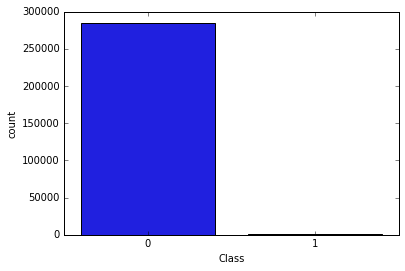

In [11]:
sns.countplot('Class',data=ulb)

### Experimental Setup

All features except time and amount are already scaled.
Scaling will take place inside the CV folds

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
X_df = ulb.drop(columns=['Class'])
y_df = ulb.Class
scale_cols = [X_df.columns.get_loc(c) for c in ['Amount','Time'] if c in X_df]
X = X_df.values
y = y_df.values

manager = ExperimentManager(X,y,'ULB',scalable_cols=scale_cols)

samplers = ['random','uncertainty','entropy','fraudish']

Existing manager file found, loading... Done
Existing benchmarks file found, loading... Done


#### Benchmark Control
Using full set of labeled data

In [14]:
new = manager.run_benchmark()
if new: manager.save()
print()
f1s = manager.get_benchmark(metric='f1')
mccs = manager.get_benchmark(metric='mcc')
bacs = manager.get_benchmark(metric='balanced accuracy')
for n,f1,mcc,bac in zip(f1s.keys(),f1s.values(),mccs.values(),bacs.values()):
  print("{n:<14} Benchmark | F1 score is: {a:.6f}\tMCC is: {b:.6f}\tBalanced Accuracy is {c:.6f}".format(n=n,a=f1,b=mcc,c=bac))

Using loaded benchmarks. Running the models on the full datasets is very time consuming, so this is using preloaded values.
If you need to run the benchmarks for all models, set override=True

Extra Forest   Benchmark | F1 score is: 0.848496	MCC is: 0.855054	Balanced Accuracy is 0.883968
Logistic SGD   Benchmark | F1 score is: 0.723503	MCC is: 0.727125	Balanced Accuracy is 0.833056
Naive Bayes    Benchmark | F1 score is: 0.114891	MCC is: 0.222612	Balanced Accuracy is 0.903509
MLP            Benchmark | F1 score is: 0.821551	MCC is: 0.824556	Balanced Accuracy is 0.889942
Dummy          Benchmark | F1 score is: 0.000000	MCC is: 0.000000	Balanced Accuracy is 0.500000


#### Random Sampling

Experiment 'random' already executed on ULB dataset.
Will run on new models only.
To replace existing values, set override=True


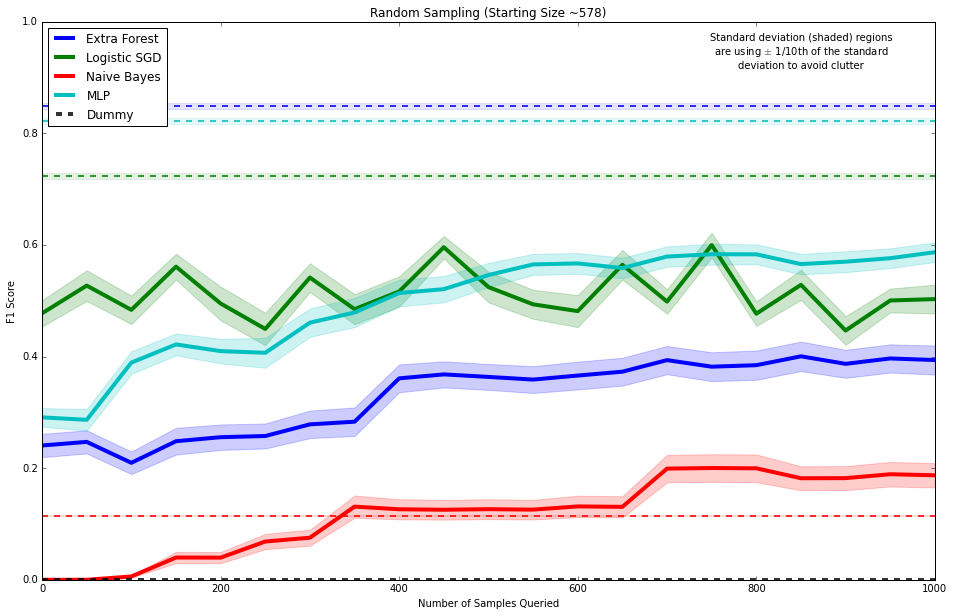

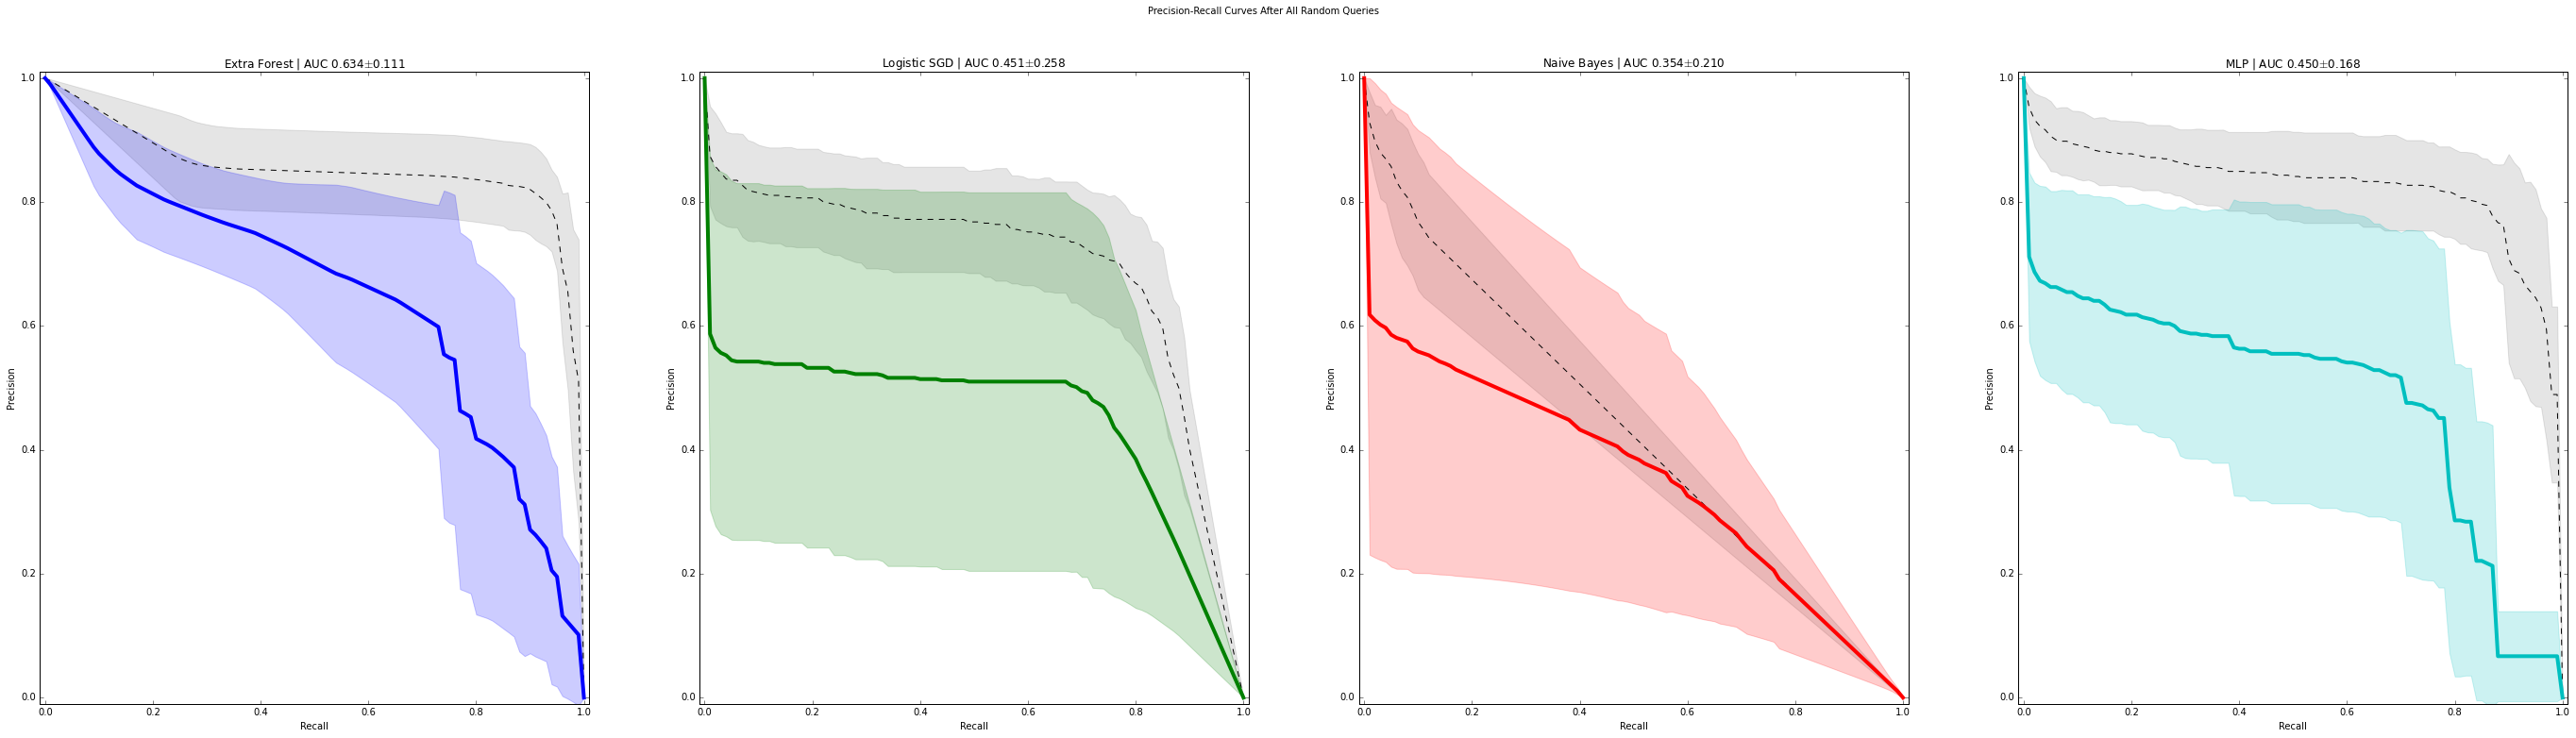

In [15]:
new = manager.run_experiment_test('random')
if new: manager.save()
manager.plot_results('random', include_std=True)
manager.plot_precision_recall_curves('random')

#### Uncertainty Sampling

Experiment 'uncertainty' already executed on ULB dataset.
Will run on new models only.
To replace existing values, set override=True


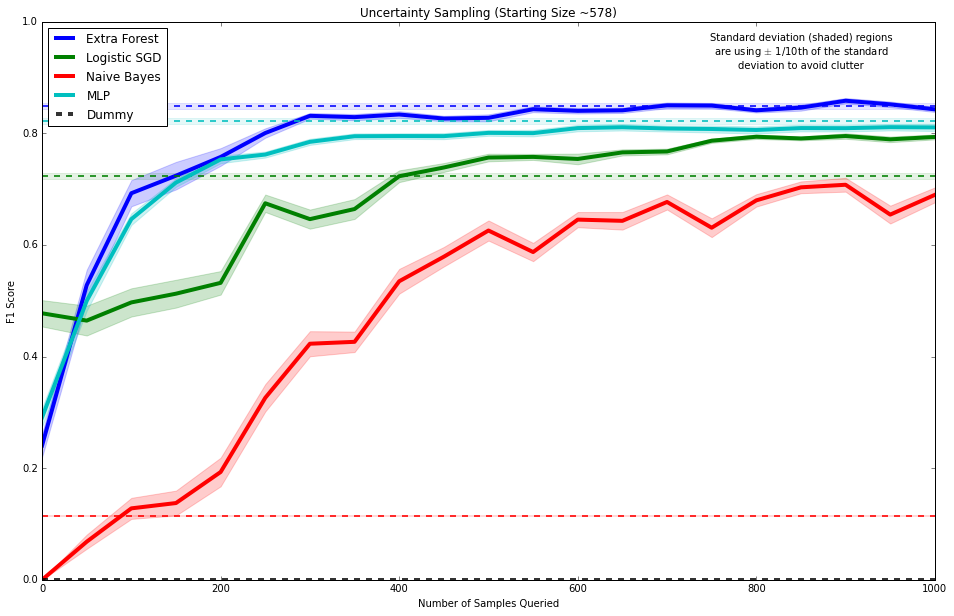

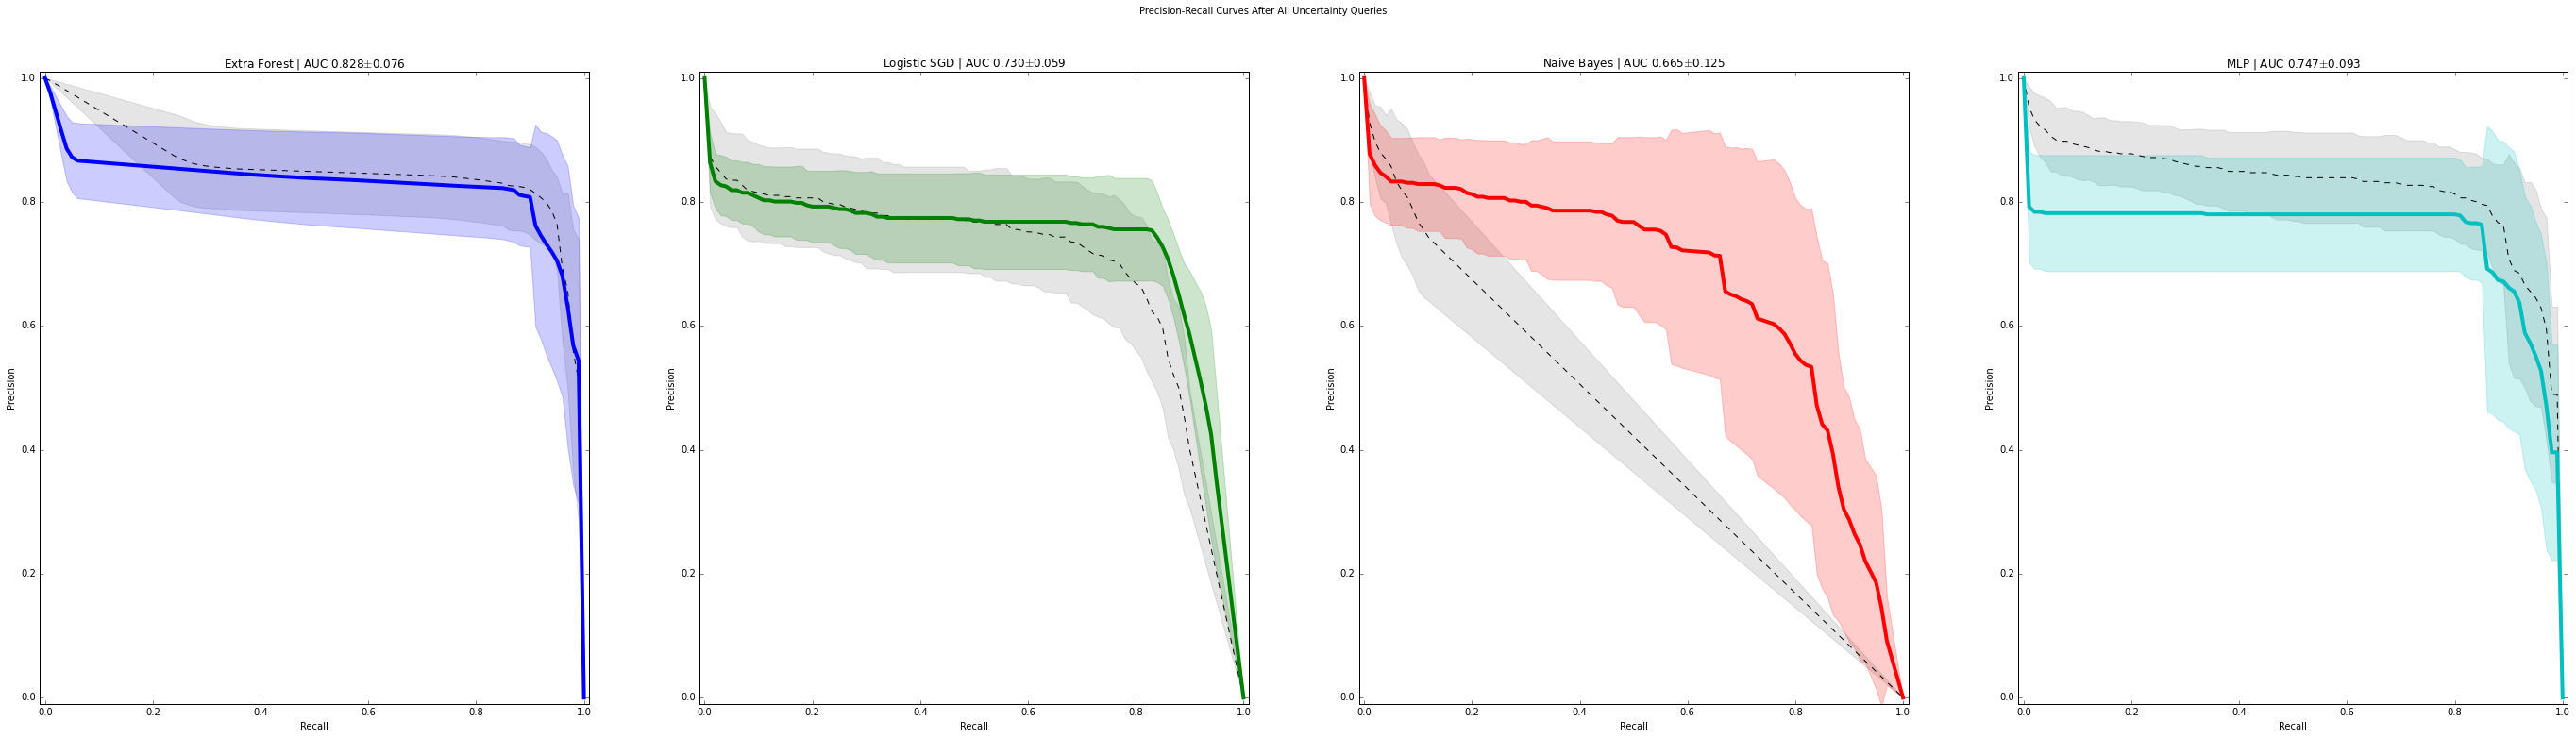

In [16]:
new = manager.run_experiment_test('uncertainty')
if new: manager.save()
manager.plot_results('uncertainty', include_std=True)
manager.plot_precision_recall_curves('uncertainty')

#### Entropy Sampling

Experiment 'entropy' already executed on ULB dataset.
Will run on new models only.
To replace existing values, set override=True


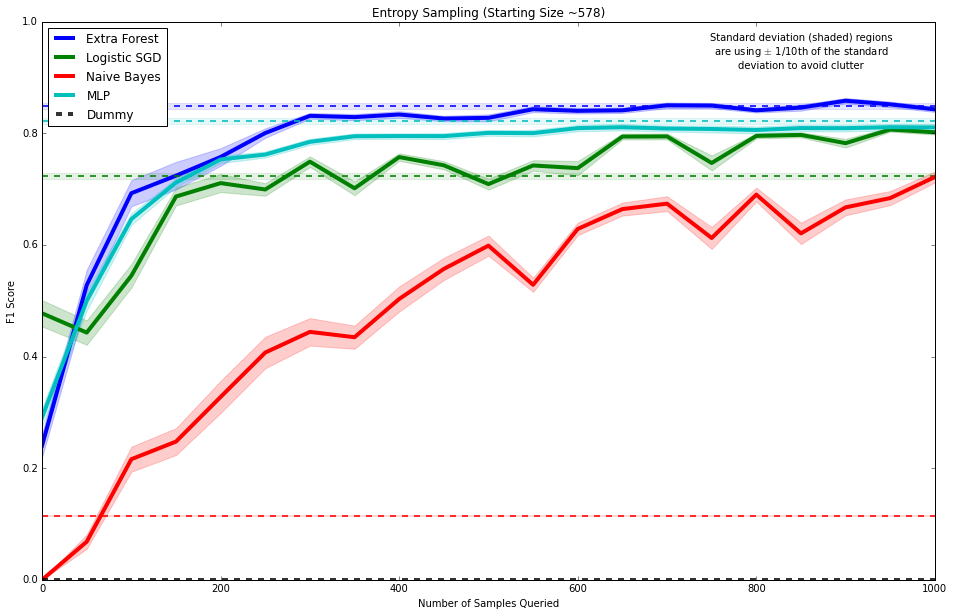

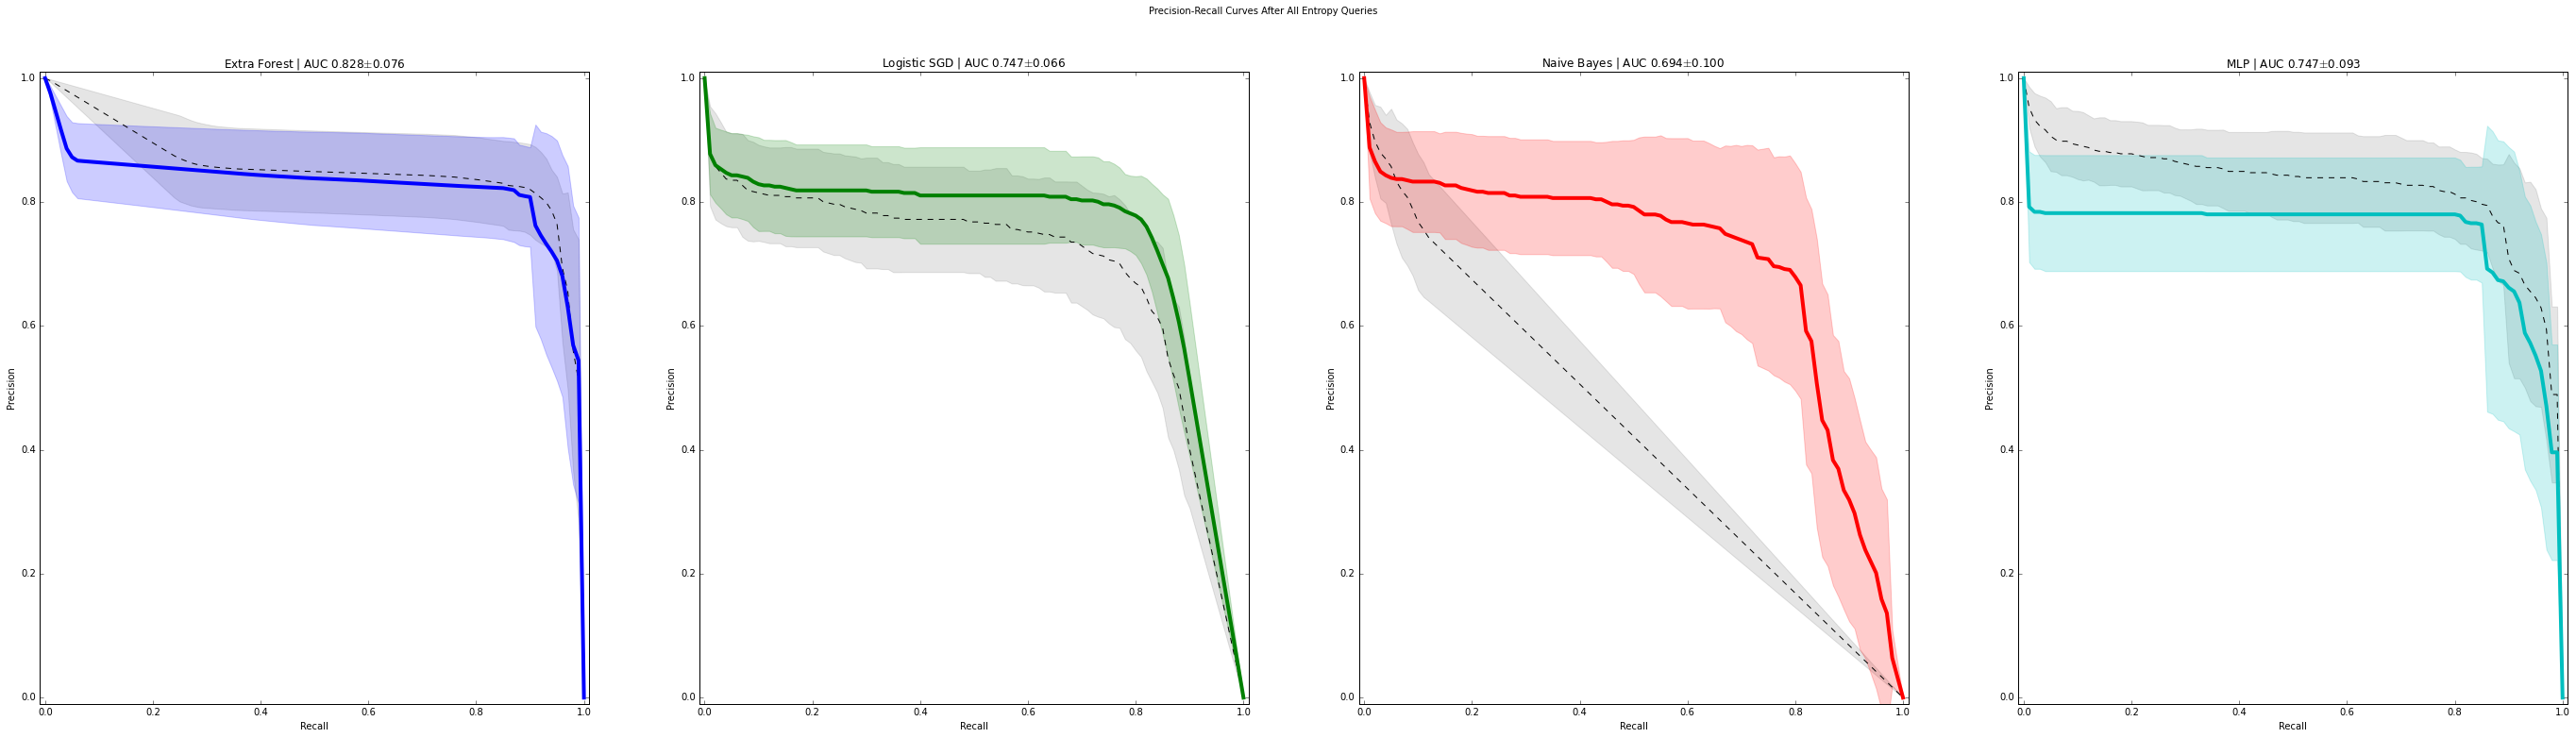

In [17]:
new = manager.run_experiment_test('entropy')
if new: manager.save()
manager.plot_results('entropy', include_std=True)
manager.plot_precision_recall_curves('entropy')

#### Likely to be Fraud Sampling
AKA Fraudish Sampling

Experiment 'fraudish' already executed on ULB dataset.
Will run on new models only.
To replace existing values, set override=True


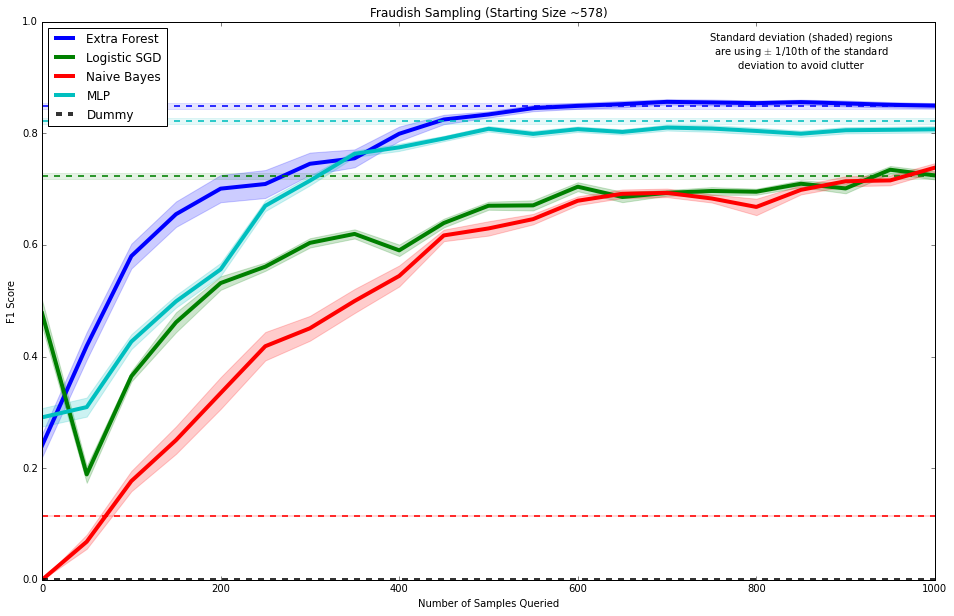

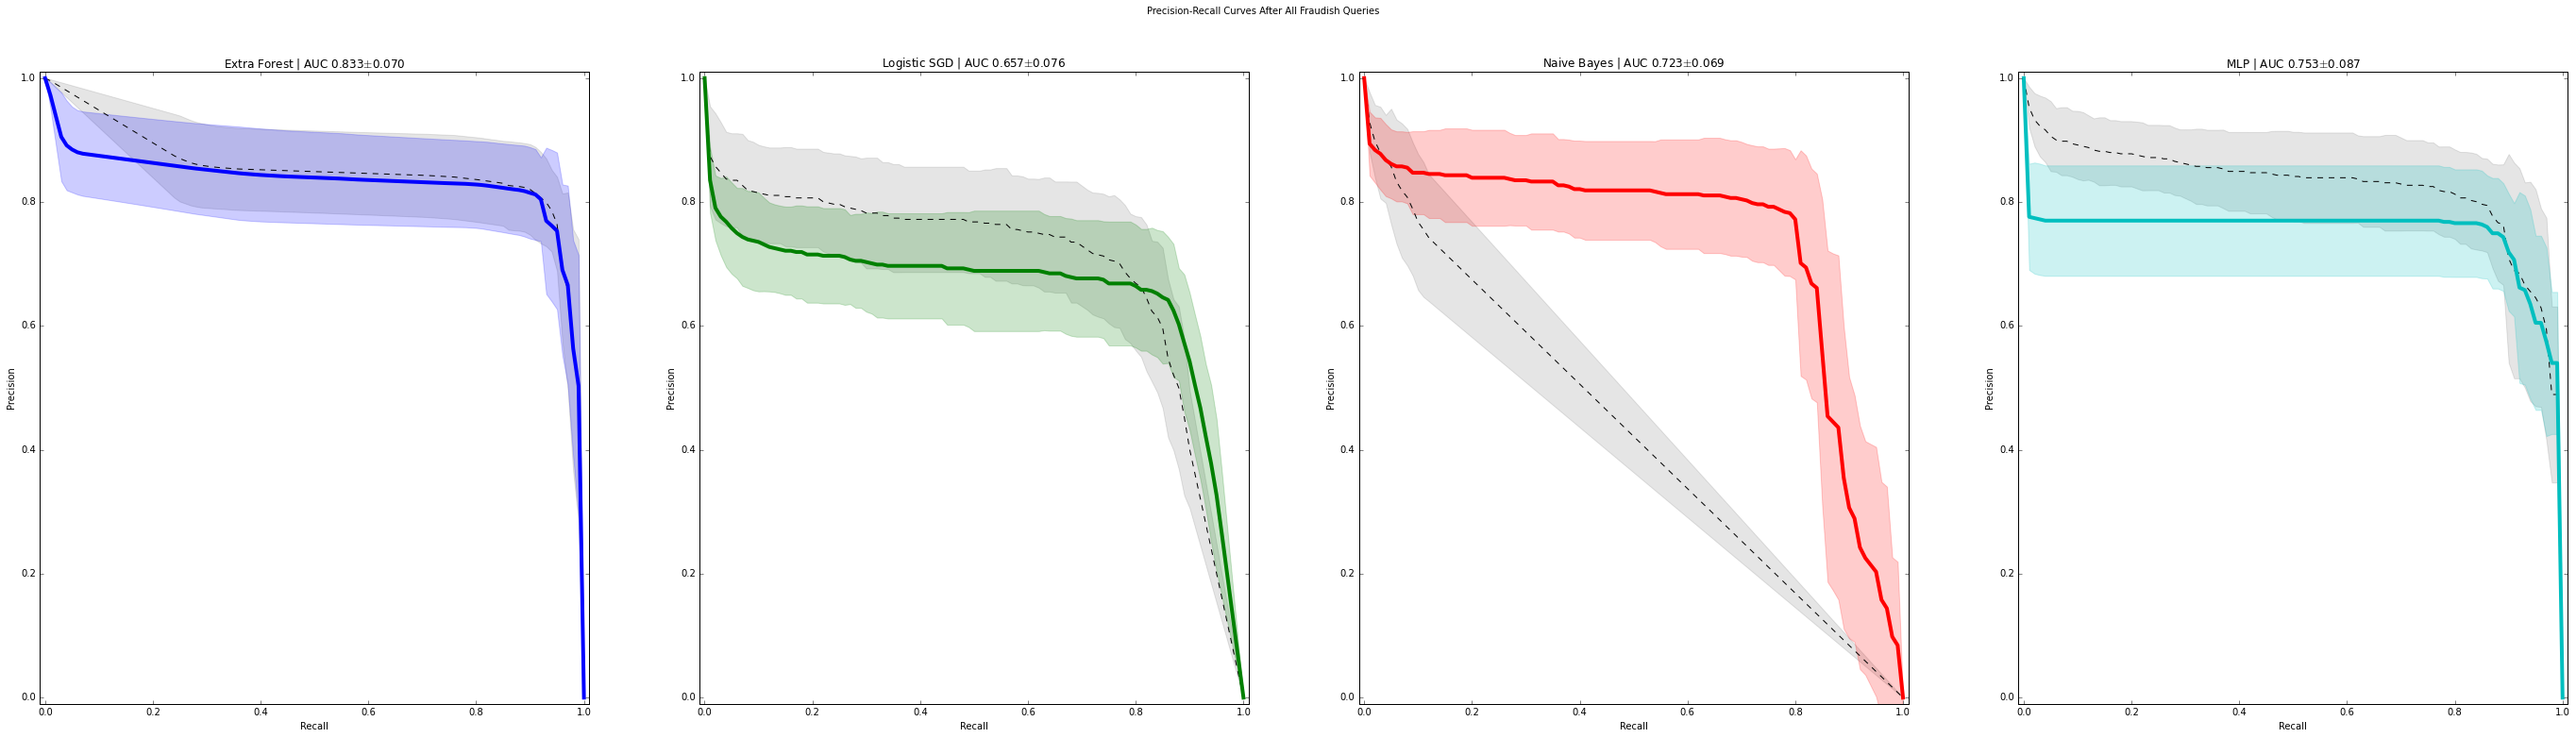

In [18]:
new = manager.run_experiment_test('fraudish')
if new: manager.save()
manager.plot_results('fraudish', include_std=True)
manager.plot_precision_recall_curves('fraudish')

#### Per-Model View

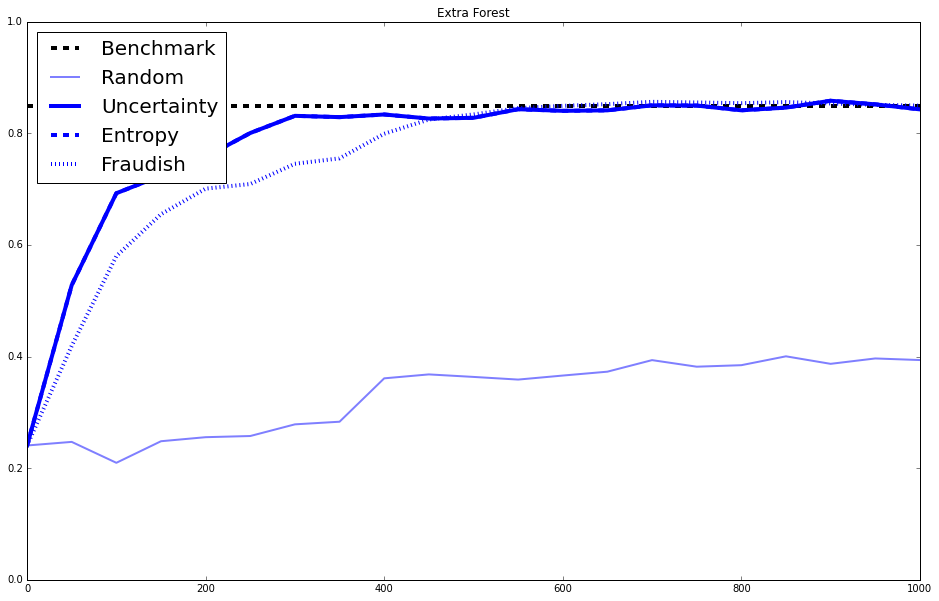

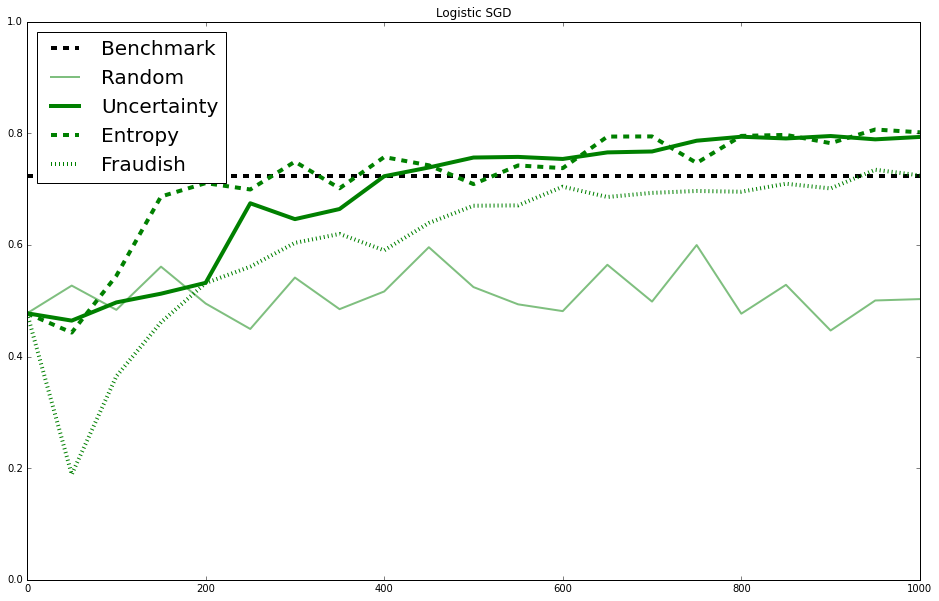

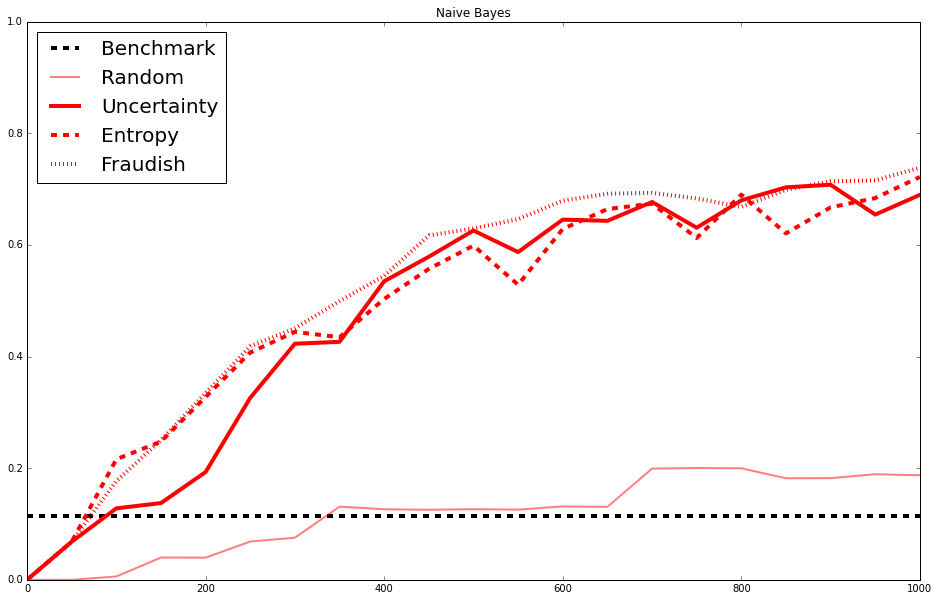

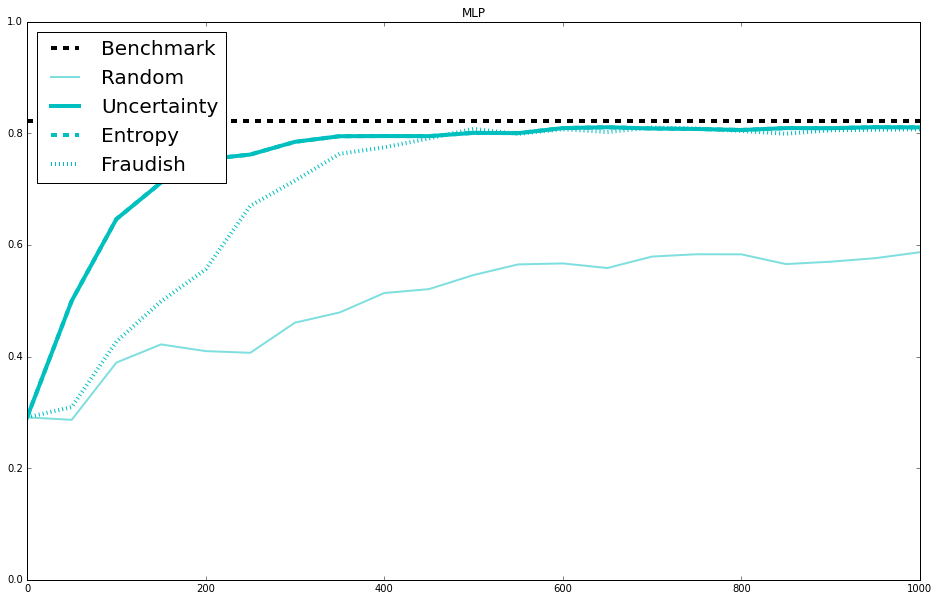

In [19]:
manager.plot_per_model()

In [20]:
gc.collect()

47537

## Dataset 2: IEEE

In [21]:
if not (path.exists("/content/ieee/train_identity.csv") and path.exists("/content/ieee/train_transaction.csv")):
  !mkdir ieee
  !kaggle competitions download -c ieee-fraud-detection
  !unzip train_identity.csv.zip -d ieee
  !unzip train_transaction.csv.zip -d ieee
  !rm sample_submission.csv.zip test_identity.csv.zip test_transaction.csv.zip train_identity.csv.zip train_transaction.csv.zip

In [22]:
ieee_a = pd.read_csv("ieee/train_transaction.csv")
ieee_b = pd.read_csv("ieee/train_identity.csv")

### Preprocessing

`id_split` function courtesy of [David Cairuz](https://www.kaggle.com/davidcairuz)

In [23]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [24]:
ieee_b = id_split(ieee_b)

In [25]:
ieee = ieee_a.merge(ieee_b, how='left', left_index=True, right_index=True)
del ieee_a, ieee_b

These useful features come from recursive feature elimination on this dataset. From [this kernel](https://www.kaggle.com/nroman/recursive-feature-elimination) by [nroman](https://www.kaggle.com/nroman)

In [26]:
useful_features = ['isFraud','TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_32',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [27]:
ieee = ieee.drop(columns=ieee.columns.difference(useful_features))
ieee = ieee.astype({'screen_width':float,'screen_height':float})

In [28]:
ieee.shape

(590540, 285)

This dataset is too large, we can start by getting rid of all rows with too many missing values.

In [29]:
ieee = ieee.dropna(thresh=140)

In [30]:
ieee.isna().sum().sum()

20274174

Impute the rest naively

In [31]:
# for col in ieee:
#     dt = ieee[col].dtype 
#     if dt == int or dt == float:
#       ieee[col].fillna(ieee[col].mean(), inplace=True)
    # else:
    #     ieee[col].fillna(ieee[col].mode().iloc[0], inplace=True)

In [32]:
ieee.isna().sum().sum()

20274174

It's now closer in size to dataset 1

In [33]:
ieee.shape

(196688, 285)

In [34]:
# def section(name, columns, X, n=6):
#   V = X[columns]
#   ind = V.select_dtypes(include='number').isnull().astype(float).add_suffix('_indicator')
#   for col in V:
#     dt = V[col].dtype
#     if dt == int or dt == float:
#       V[col] = V[col].fillna(V[col].mean())
#   V = pd.get_dummies(V)
#   V = pd.concat([V,ind],axis=1)
#   V = RobustScaler().fit_transform(V)
#   pca = PCA(n_components=n)
#   V = pca.fit_transform(V)
#   X = X.drop(columns=columns)
#   for i in range(n):
#     X['{n}_PCA{q}'.format(n=name,q=(i+1))] = V[:,i]
#   gc.collect()
#   return X


# X_df = section('C',['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'], X_df)
# X_df = section('D',['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'], X_df)
# X_df = section('M',['M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], X_df)
# X_df = section('V',['V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
#                    'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
#                    'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
#                    'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
#                    'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
#                    'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
#                    'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
#                    'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
#                    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
#                    'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
#                    'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
#                    'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
#                    'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
#                    'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
#                    'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338'], X_df)
# X_df = section('ID',['id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
#                    'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_32',
#                    'id_36', 'id_37', 'id_38', 'DeviceType', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
#                    'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id'], X_df)
# X_df = section('OTHER',['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
#                    'P_emaildomain', 'R_emaildomain'],X_df)

In [35]:
y_df = ieee.isFraud
X_df = pd.get_dummies(ieee.drop(columns=['isFraud']))
del ieee
gc.collect()

0

In [36]:
X_df.shape

(196688, 842)

In [37]:
X_df.isna().sum().sum()

17734989

Classes in dataset 2 are still hightly imbalanced, but not as much so as dataset 1

In [38]:
y_df.value_counts()

0    184605
1     12083
Name: isFraud, dtype: int64

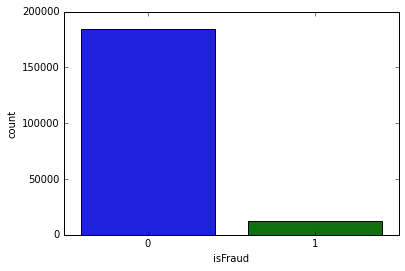

In [39]:
sns.countplot(x=y_df)

### Experimental Setup

In [40]:
X = X_df.values
y = y_df.values
del X_df, y_df

To save time having to scale & PCA the data again, which takes a long time, I will load the previously preprocessed splits (saved when setting use_memmap=True).

As with the ?_benchmark.xz and ?_manager.xz files, the stored splits are dependent on the seed being correct (`0xDDDDDDDD`), if the seed is changed, the splits need to be generated and preprocessed again. I should really also save/load the seed with the memmaps and/or xz files so it's consistent no matter what, but I don't have time to at the moment

In [41]:
manager = ExperimentManager(X,y,'IEEE',scalable_cols='all', reduce_to=80, use_memmap=True)
samplers = ['random','uncertainty','entropy','fraudish']

Existing manager file found, loading... Done
Existing benchmarks file found, loading... Done


In [42]:
new = manager.run_benchmark()
if new: manager.save()
print()
f1s = manager.get_benchmark(metric='f1')
mccs = manager.get_benchmark(metric='mcc')
bacs = manager.get_benchmark(metric='balanced accuracy')
for n,f1,mcc,bac in zip(f1s.keys(),f1s.values(),mccs.values(),bacs.values()):
  print("{n:<14} Benchmark | F1 score is: {a:.6f}\tMCC is: {b:.6f}\tBalanced Accuracy is {c:.6f}".format(n=n,a=f1,b=mcc,c=bac))


Extra Forest   Benchmark | F1 score is: 0.612641	MCC is: 0.620554	Balanced Accuracy is 0.737739
Logistic SGD   Benchmark | F1 score is: 0.320091	MCC is: 0.293121	Balanced Accuracy is 0.724638
Naive Bayes    Benchmark | F1 score is: 0.127368	MCC is: 0.061539	Balanced Accuracy is 0.549601
MLP            Benchmark | F1 score is: 0.525821	MCC is: 0.541474	Balanced Accuracy is 0.695062
Dummy          Benchmark | F1 score is: 0.000000	MCC is: 0.000000	Balanced Accuracy is 0.500000


In [43]:
gc.collect()

312

In [44]:
# new = manager.run_benchmark()
# if new: manager.save()
# print()
# f1s = manager.get_benchmark(metric='f1')
# mccs = manager.get_benchmark(metric='mcc')
# bacs = manager.get_benchmark(metric='balanced accuracy')
# for n,f1,mcc,bac in zip(f1s.keys(),f1s.values(),mccs.values(),bacs.values()):
#   print("{n:<14} Benchmark | F1 score is: {a:.6f}\tMCC is: {b:.6f}\tBalanced Accuracy is {c:.6f}".format(n=n,a=f1,b=mcc,c=bac))

#### Random Sampling

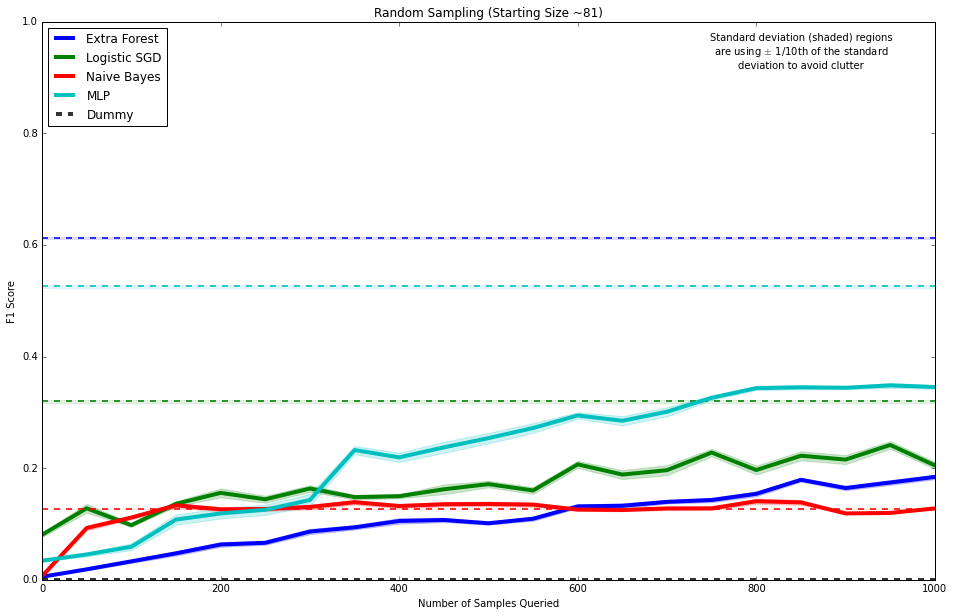

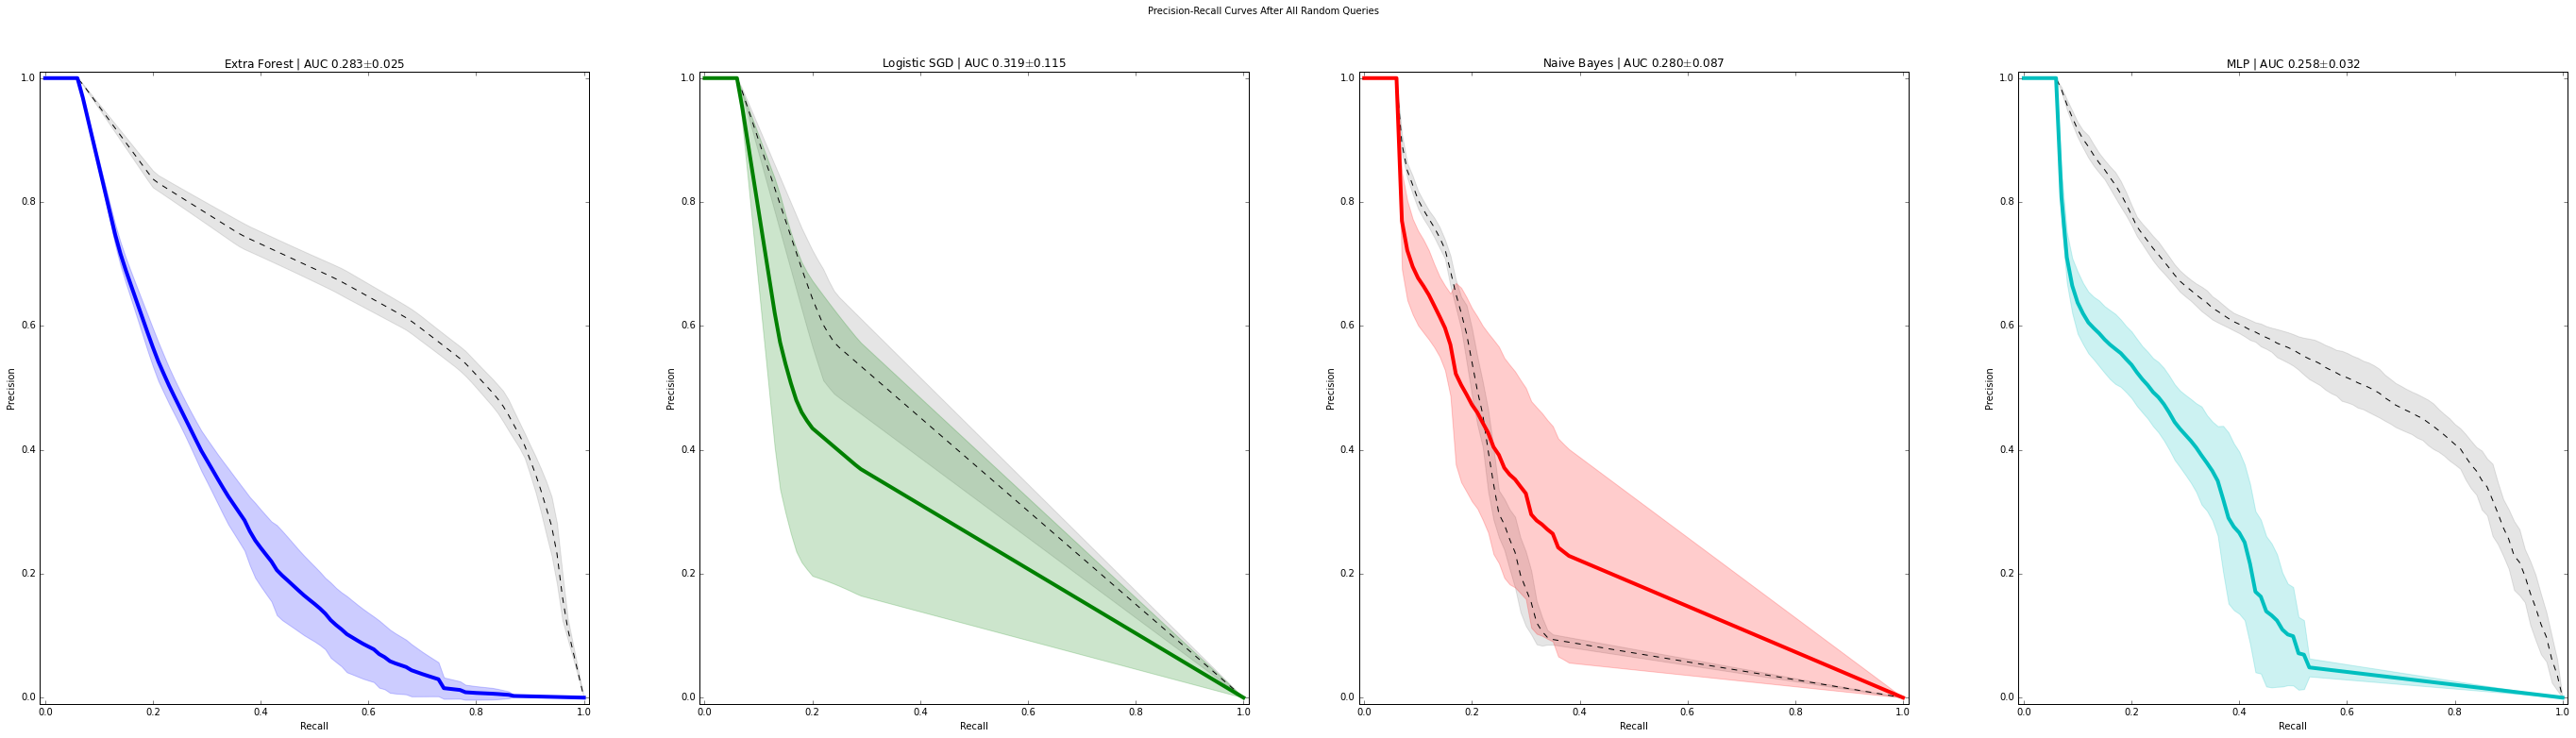

In [45]:
new = manager.run_experiment_test('random')
if new: manager.save()
manager.plot_results('random', include_std=True)
manager.plot_precision_recall_curves('random')

#### Uncertainty Sampling

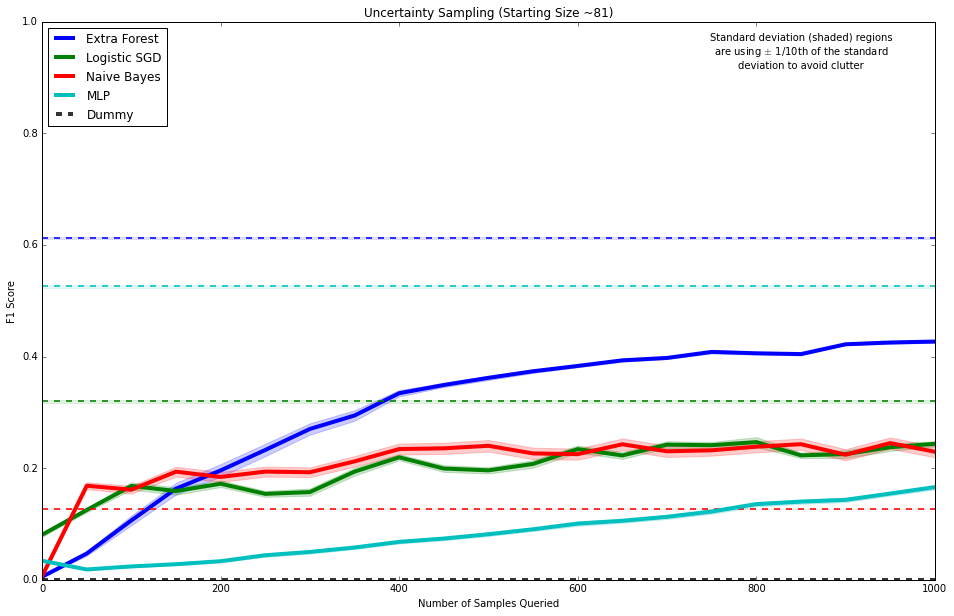

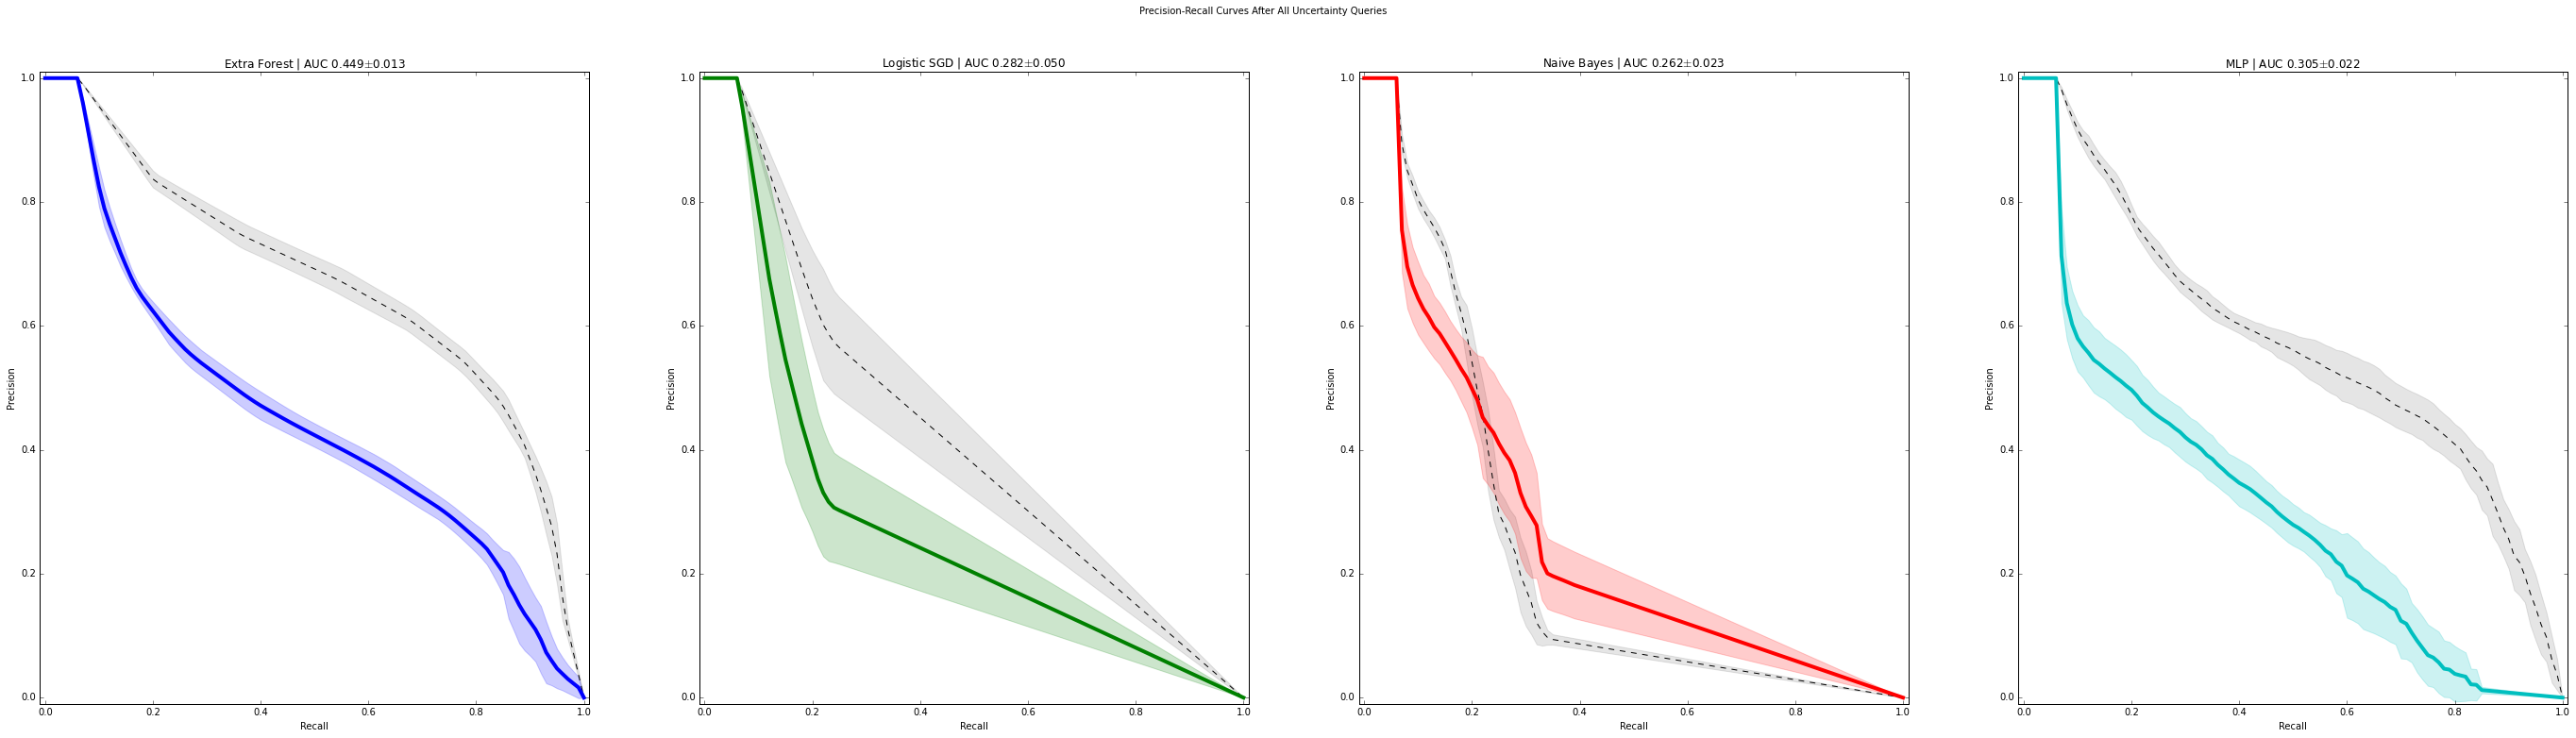

In [46]:
new = manager.run_experiment_test('uncertainty')
if new: manager.save()
manager.plot_results('uncertainty', include_std=True)
manager.plot_precision_recall_curves('uncertainty')

#### Entropy Sampling

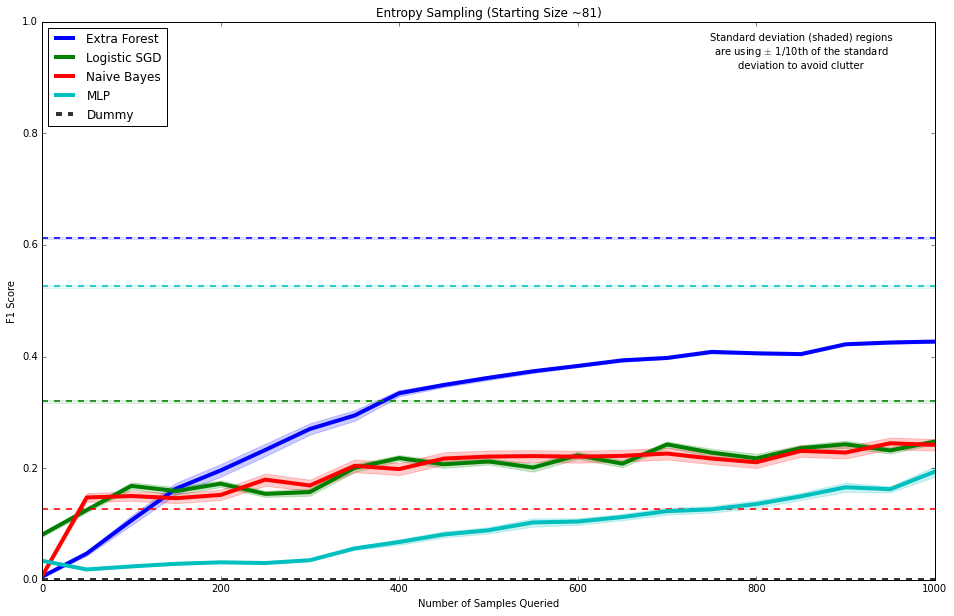

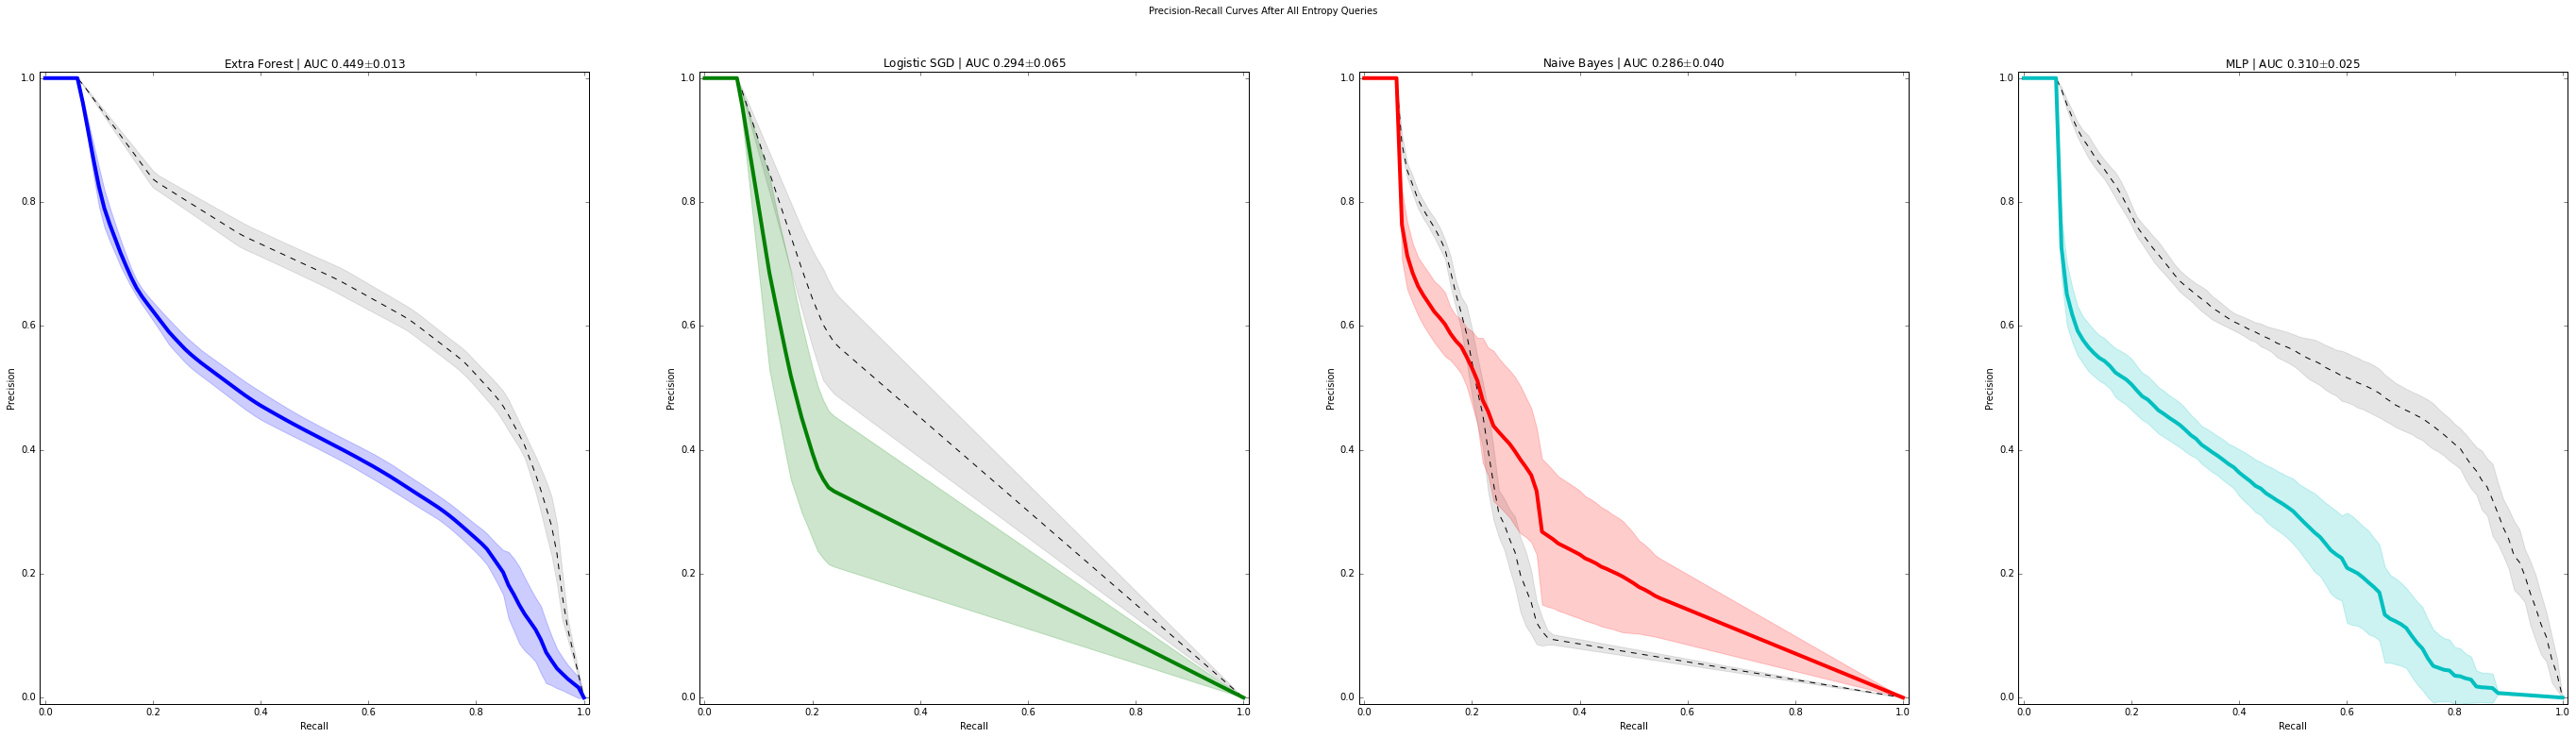

In [47]:
new = manager.run_experiment_test('entropy')
if new: manager.save()
manager.plot_results('entropy', include_std=True)
manager.plot_precision_recall_curves('entropy')

#### Likely to be Fraud Sampling
AKA Fraudish Sampling

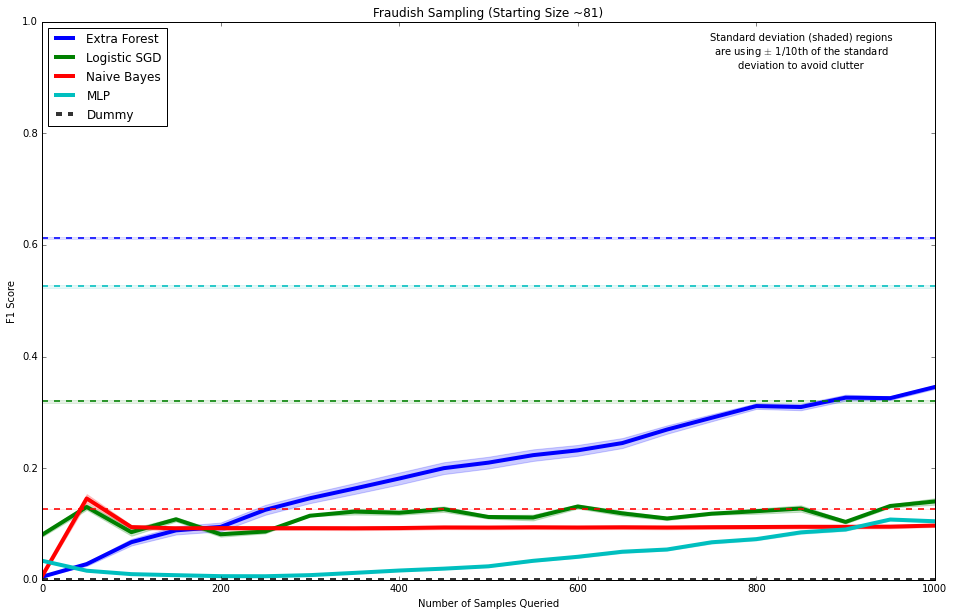

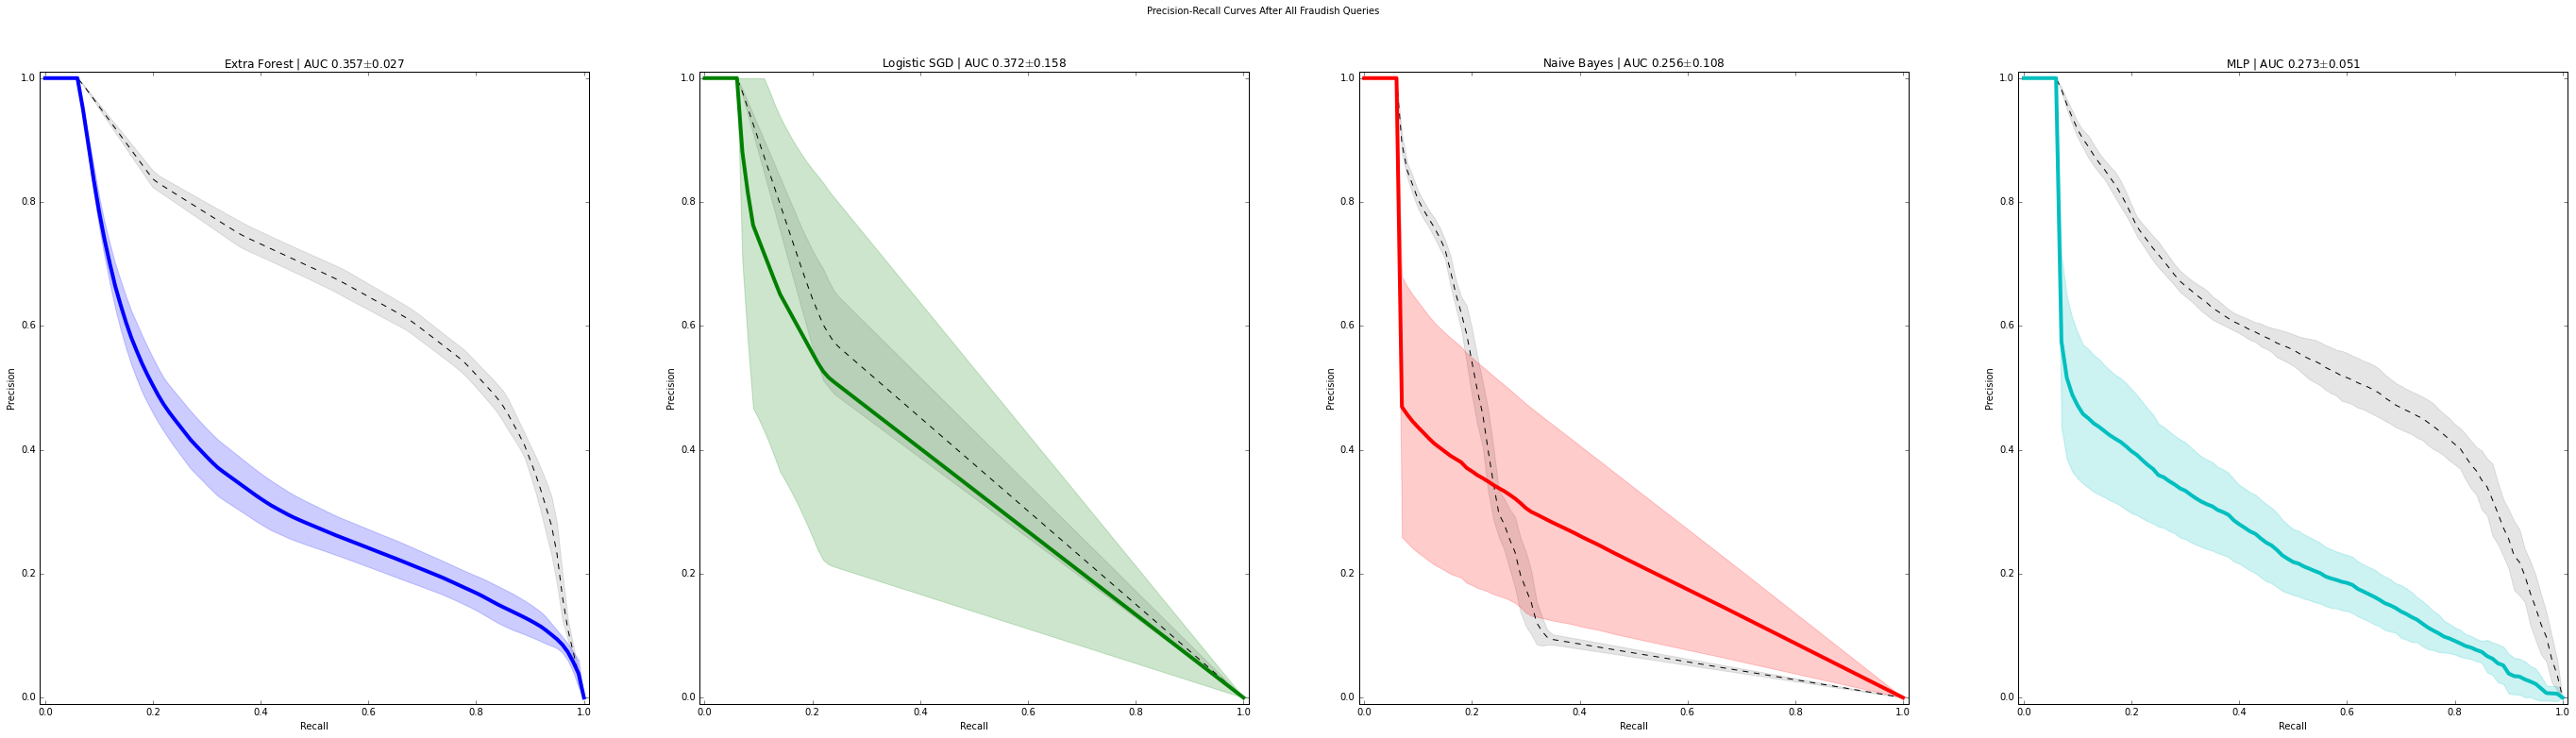

In [48]:
new = manager.run_experiment_test('fraudish')
if new: manager.save()
manager.plot_results('fraudish', include_std=True)
manager.plot_precision_recall_curves('fraudish')

#### Per-Model View

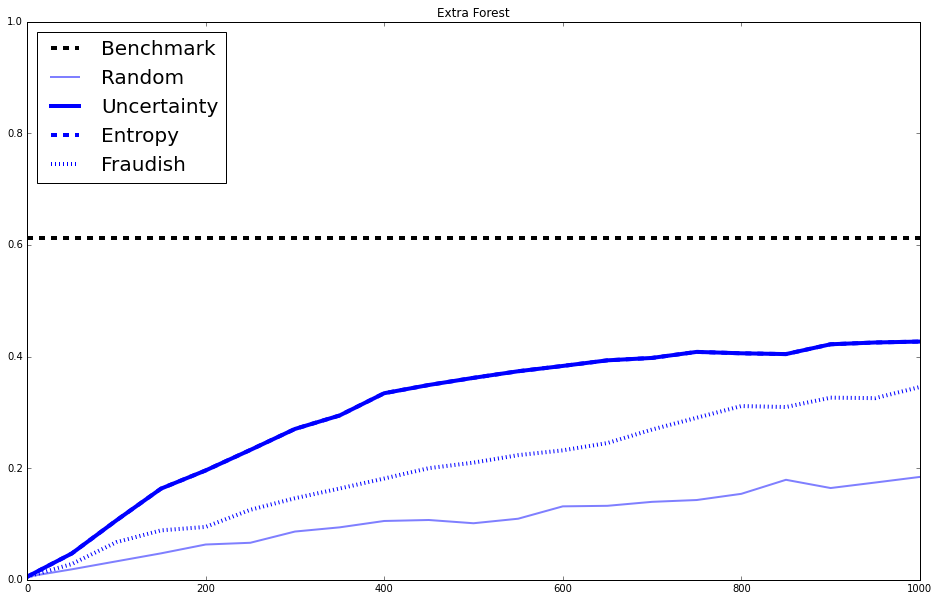

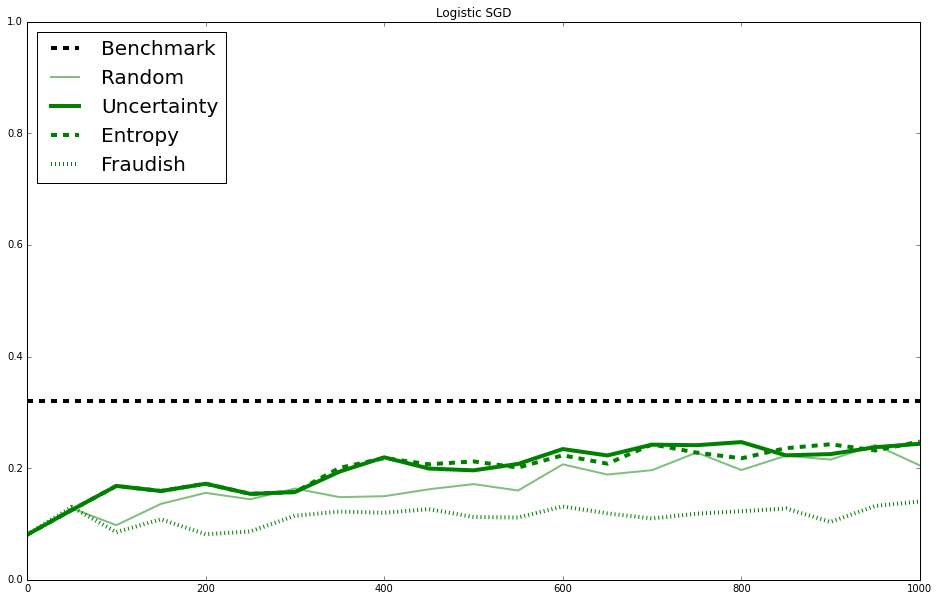

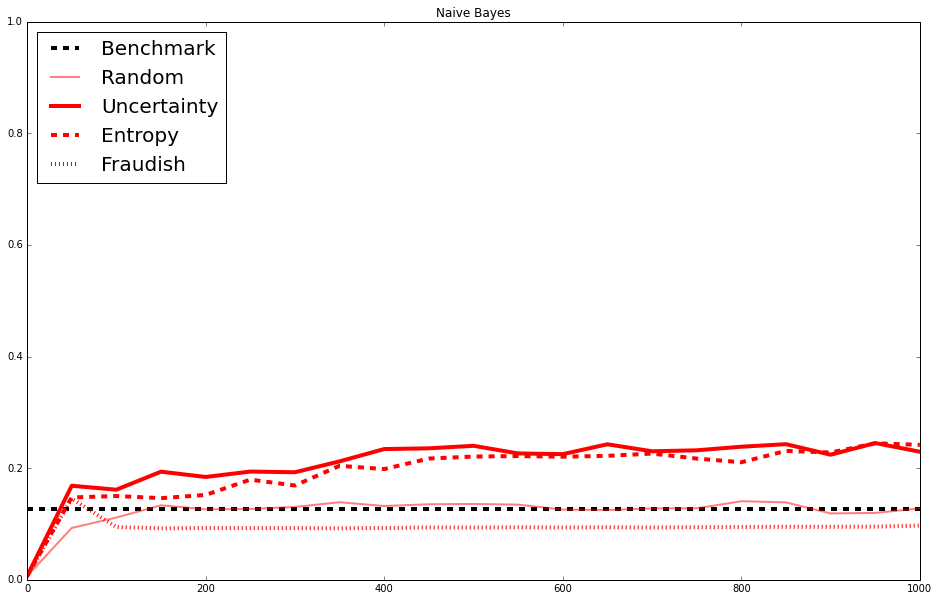

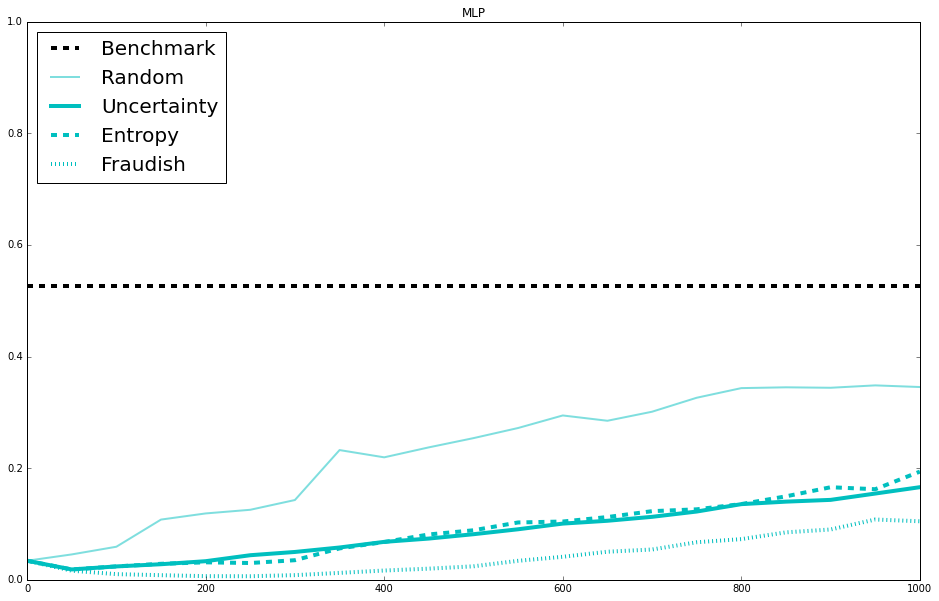

In [49]:
manager.plot_per_model()

In [50]:
gc.collect()

43582

## Dataset 3 Banknotes

# OLD


In [ ]:
# Generalized
class Oracle():
  def __init__(self, cost, accuracy, seed):
    self.rng = np.random.RandomState()
    self.seed = seed
    self.rng.seed(seed)
    self.cost = cost
    self.accuracy = accuracy
  #   self.already_labeled = []
  
  # def check_labeled(self, index):
  #   return index in self.already_labeled
  
  def reset_rng(self):
    self.rng.seed(self.seed)
  
  def get_answer(self, ground_truth):
    return ground_truth if self.rng.uniform() <= self.accuracy else 1-ground_truth

class ExperimentManager():
  def __init__(self, X, y, dataset_name, cols_to_scale=None, base_models=None, initial_pool=10, default_queries=100, cv_folds=10, seed=SEED):
    self.name = dataset_name
    self.X = X
    self.y = y
    self.seed = seed
    self.rng = np.random.RandomState()
    self.__reset_rng()

    self.oracles = [Oracle(0.1,1,self.rng.randint(np.iinfo(np.uint32).max,dtype=np.uint32)),Oracle(0.01,0.9,self.rng.randint(np.iinfo(np.uint32).max,dtype=np.uint32))]

    self.__reset_rng()

    self.budget = 1.0

    '''
    List containing tuples of cv-split indices of the format (train set labeled, train set unlabeled, test set)
    '''
    self.splits = []

    # if initial_pool <= 0.5:
    #   big_fold = False
    #   pool_fold = round(1/initial_pool)
    # else:
    #   big_fold = True
    #   pool_fold = round(1/(1.0-initial_pool))

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.seed)
    for train_i, test_i in cv.split(self.X, self.y):
      # Q = train_i[self.y[train_i]==1]
      # q = train_i[self.y[train_i]==0]
      # train_l_i = np.concatenate([Q[self.rng.randint(Q.shape[0],size=1)],q[self.rng.randint(Q.shape[0],size=initial_pool-1)]])
      # train_p_i = train_i
      train_l_i, train_p_i = sk.model_selection.train_test_split(train_i, train_size=initial_pool)#, stratify=self.y[train_i])
      self.splits.append((train_l_i,train_p_i,test_i))
      # A roundabout way to get a fixed stratified subset for each fold (representing the initial pool of labeled data) is to do another StratifiedKFold on the folds training set
      
      # big, small = next(StratifiedKFold(n_splits=pool_fold, shuffle=True,random_state=self.seed).split(X[train_i],y[train_i]))
      # #                     (train set labeled, train set unlabeled,  test set)
      # if big_fold:
      #   self.splits.append( (train_i[big],      train_i[small],       test_i))
      # else:
      #   self.splits.append( (train_i[small],    train_i[big],         test_i))

    # Do not train.
    self.base_models = [DecisionTreeClassifier(), ExtraTreesClassifier(n_estimators=50), KNeighborsClassifier(n_jobs=-1), SVC(cache_size=500, probability=True), SGDClassifier(loss='log')] if base_models is None else base_models.values()
    self.base_model_names = ['Decision Tree', 'Extra Forest', 'KNN', 'SVM', 'Logistic SGD'] if base_models is None else base_models.keys()
    # self.base_models = [ExtraTreesClassifier(n_estimators=10),LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto')] if base_models is None else base_models.values()
    # self.base_model_names = ['Extra Forest', 'LDA'] if base_models is None else base_models.keys()

    self.M = len(self.base_models)
    self.F = cv_folds
    self.default_queries = default_queries

    '''
    experiments format: {'Experiment1':results1, 'Experiment2':results2, 'ExperimentN':resultsN}

    results format: numpy array of shape (M, F, K, V) where
    M is the number of models the experiment manager is testing, corresponding to the order of self.base_models & self.base_model_names - Per experiment manager
    F is the number of cross validation folds tested                                                                                    - Per experiment manager
    K is the number of active learning queries performed (e.g how many new samples are labeled) + 1 for the initial pool query.         - Per experiment
    V is 5, containing [spent budget, TN, FP, FN, TP]                                                                                   - Fixed

    Thus a value at results1[m,f,k] represents the confusion matrix values for for Experiment1 on model m, using fold f, after k queries.
    '''
    self.experiments = {}

  def __reset_rng(self):
    self.rng.seed(self.seed)

  '''
  equivalent to initial_pool=1 
  '''
  def run_full_set_control(self, verbose=False):
    loading_bar = display(progress(0, self.M*self.F), display_id=True)
    results = np.zeros((self.M,self.F,1,4))
    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      for split in self.splits:
        self.__reset_rng()

        if verbose:
          print("{name} fold {fold}:".format(name=name,fold=f), end=" ")

        train_i, test_i = np.concatenate(split[:2]), split[2]

        X_train, X_test = self.X[train_i], self.X[test_i]
        y_train, y_test = self.y[train_i], self.y[test_i]

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed) 

        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        results[m,f,0] = confusion_matrix(y_test, pred).ravel()

        loading_bar.update(progress(m*self.F+f+1,self.M*self.F))
        if verbose:
          print("DONE")

        f += 1
      m +=1
    self.experiments['Control - All Data'] = results

  def run_experiment_simple(self, title, query_method, oracle_method, random=False, verbose=False):
    # K = self.default_queries if queries is None or queries<0 else queries
    # K += 1

    loading_bar = display(progress(0, self.M*self.F), display_id=True)
    self.budget = 1.0
    
    #results = np.zeros((self.M,self.F,K,5))
    results = []
    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      folds = []
      for split in self.splits:
        self.__reset_rng()

        values = []

        if verbose:
          print("{name} fold {fold} |".format(name=name,fold=f), end=" ")

        X_train, X_pool, X_test = self.X[split[0]], self.X[split[1]], self.X[split[2]]
        y_train, y_pool, y_test = self.y[split[0]], self.y[split[1]], self.y[split[2]]

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)

        learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train)

        pred = learner.predict(X_test)

        c = np.zeros(5)
        c[0] = 0
        c[1:] = confusion_matrix(y_test, pred).ravel()
        values.append(c)

        #results[m,f,0,0] = 0
        #results[m,f,0,1:] = confusion_matrix(y_test, pred).ravel()
        
        if verbose:
          print("Unqueried", end=" | ")

        while self.budget > 0:
          if random:
            query_index = self.rng.randint(X_pool.shape[0]+1)
          else:
            query_index, _ = learner.query(X_pool)

          X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )

          oracle = oracle_method(self.oracles, self.budget)
          oracle_answer = oracle.get_answer(y)
          learner.teach(X=X, y=oracle_answer)
          self.budget -= oracle.cost

          X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

          pred = learner.predict(X_test)

          c = np.zeros(5)
          c[0] = 1-self.budget
          c[1:] = confusion_matrix(y_test, pred).ravel()
          values.append(c)
          #results[m,f,k, 0] = 1-self.budget
          #results[m,f,k, 1:] = confusion_matrix(y_test, pred).ravel()

          #loading_bar.update(progress(m*self.F*K+f*K+k+1,self.M*self.F*K))
          # if verbose:
          #   print(k, end=", ")
          
        loading_bar.update(progress(m*self.F+f+1,self.M*self.F))
          
        if verbose:
          print("DONE")

        f += 1
        folds.append(np.array(values))
        self.budget = 1.0

      results.append(folds)
      m +=1
    
    self.experiments[title] = results
    

  def run_experiment_advanced(self, title, integrated_method, verbose=False):
    pass
  
  def run_experiment_test(self, title, queries=None, verbose=False, random=False):
    '''
    '''
    K = self.default_queries if queries is None or queries<0 else queries
    K += 1

    loading_bar = display(progress(0, self.M*self.F*K), display_id=True)
    
    results = np.zeros((self.M,self.F,K,4))
    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      for split in self.splits:
        self.__reset_rng()

        if verbose:
          print("{name} fold {fold} |".format(name=name,fold=f), end=" ")

        X_train, X_pool, X_test = self.X[split[0]], self.X[split[1]], self.X[split[2]]
        y_train, y_pool, y_test = self.y[split[0]], self.y[split[1]], self.y[split[2]]

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)

        learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train)

        pred = learner.predict(X_test)
        results[m,f,0] = confusion_matrix(y_test, pred).ravel()
        loading_bar.update(progress(m*self.F*K+f*K+1,self.M*self.F*K))
        if verbose:
          print("Unqueried", end=" | ")

        for k in range(1,K):
          if random:
            query_index = self.rng.randint(X_pool.shape[0]+1)
          else:
            query_index, _ = learner.query(X_pool)

          X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
          learner.teach(X=X, y=y)

          X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

          pred = learner.predict(X_test)
          results[m,f,k] = confusion_matrix(y_test, pred).ravel()

          loading_bar.update(progress(m*self.F*K+f*K+k+1,self.M*self.F*K))
          if verbose:
            print(k, end=", ")
          
        if verbose:
          print("DONE")

        f += 1
      m +=1
    
    self.experiments[title] = results


  # TODO. Finish properly
  def get_result(self, experiment=None, model='all', metric=None, queries='all', fold=None, budget_step=0.01):
    if experiment is None: return

    result = self.experiments[experiment]
    dim_names = np.array(['Experiment','Model','Fold','Kth-Query','Confusion Values'])

    if queries=='all':
      num = int(np.ceil(1/budget_step)+1)
      x = np.linspace(0,1,num=num)
      i_result = np.zeros((self.M,self.F,num,4))
      m=0
      for M in result:
        f=0
        for F in M:
          q = np.array(F)

          i_result[m,f,:,0] = np.interp(x,q[:,0],q[:,1])
          i_result[m,f,:,1] = np.interp(x,q[:,0],q[:,2])
          i_result[m,f,:,2] = np.interp(x,q[:,0],q[:,3])
          i_result[m,f,:,3] = np.interp(x,q[:,0],q[:,4])

          f+=1
        m+=1

      result = i_result

      # #result_dict
      if metric is not None:
        TN, FP, FN, TP = result[...,0], result[...,1], result[...,2], result[...,3]
        if metric=='tn': result = TN
        elif metric=='fp': result = FP
        elif metric=='fn': result = FN
        elif metric=='tp': result = TP
        elif metric=='recall': result = TP/(TP+FN)
        elif metric=='precision': retult = TP/(TP+FP)
        elif metric=='mcc': result = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        elif metric=='f1': result = TP/(TP+0.5*(FP+FN))

        result = np.expand_dims(result,-1)

      if model is None or model=='avg':
        result = np.mean(result, axis=0, keepdims=True)
      if fold is None or fold=='avg':
        result = np.mean(result, axis=1, keepdims=True)
      if queries is None or queries=='last':
        result = result[:,:,-1,np.newaxis,:]
      
      return x, result

## Dataset 1: Mushrooms

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

In [ ]:
shrooms = pd.read_csv("agaricus-lepiota.data",names=['Edible','CapShape','CapSurface','CapColor','Bruises','Odor','GillAttachnent','GillSpacing','GillSize','GillColor','StalkShape','StalkRoot','StalkSurfaceAboveRing','StalkSurfaceBelowRing','StalkColorAboveRing','StalkColorBelowRing','VeilType','VeilColor','RingNumber','RingType','SporePrintColor','Population','Habitat'])

In [ ]:
shrooms.head()

2480 missing values, all for StalkRoot

In [ ]:
(shrooms=='?').sum()

These values will be left as-is, so that when one-hot encoded the 'StalkRoot_?' column will indicate a missing value of StalkRoot for that sample

In [ ]:
X = pd.get_dummies(shrooms.drop(columns=['Edible'])).values
y = (shrooms.Edible=='e').astype(float).values

In [ ]:
manager = ExperimentManager(X,y,'Shrooms')

In [ ]:
def m0(oracle_list, current_budget):
  return oracle_list[0]

def m1(oracle_list, current_budget):
  return oracle_list[1]

In [ ]:
manager.run_experiment_simple('test0',None,m0)
manager.run_experiment_simple('test1',None,m1)

In [ ]:
x,v = manager.get_result('test0',metric='f1')
v = v[0].squeeze()
plt.figure(num=1, figsize=(16, 10))
plt.plot(x,v)
x,v = manager.get_result('test1',metric='f1')
v = v[0].squeeze()
plt.plot(x,v)

In [ ]:
#manager.run_experiment_test('test')
#manager.run_experiment_test('testRandom',random=True)

V = manager.get_result("test",metric='f1',).squeeze()
v = manager.get_result("testRandom",metric='f1',).squeeze()
q = np.arange(101)
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))

for a,b in zip(V,names):
  plt.plot(q,a,label=b+" Default Query")

plt.gca().set_prop_cycle(None)

for a,b in zip(v,names):
  plt.plot(q,a,label=b+" Random Query",linestyle='--')

plt.legend()
plt.show()

## Dataset 2: Credit

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
!unzip SouthGermanCredit.zip
!rm codetable.txt read_SouthGermanCredit.R SouthGermanCredit.zip

In [ ]:
credit = pd.read_csv('SouthGermanCredit.asc',delimiter=' ',header=0,names=['Status','Duration','CreditHistory','Purpose','Amount','Savings','EmploymentDuration','InstallmentRate','MarriageStatus','OtherDebtors','PresentResidence','Property','Age','OtherInstallmentPlans','Housing','NumberCredits','Job','PeopleLiable','Phone','ForeignWorker','CreditRisk'])

In [ ]:
credit.head()

In [ ]:
credit.isna().sum()

In [ ]:
num_cols = ['Duration','Amount','Age','CreditRisk']
credit[credit.columns.difference(num_cols)] = credit[credit.columns.difference(num_cols)].astype('category')

In [ ]:
[credit.columns.get_loc(c) for c in num_cols if c in credit]

In [ ]:
X = pd.get_dummies(credit.drop(columns=['CreditRisk'])).values
y = credit.CreditRisk.values

In [ ]:
manager = ExperimentManager(X,y,'Credit')

In [ ]:
manager.run_experiment_test('test')
manager.run_experiment_test('testRandom',random=True)
V = manager.get_result("test",metric='f1',).squeeze()
v = manager.get_result("testRandom",metric='f1',).squeeze()
q = np.arange(101)
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,v[0],label=names[0])
plt.plot(q,v[1],label=names[1])
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
#plt.plot(q,V[2],label=names[2])
plt.legend()
plt.show()

## Dataset 2: UCI

In [ ]:
!mkdir uci
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt -P /content/uci

In [ ]:
uci = pd.read_csv('uci/data_banknote_authentication.txt',names=['WaveletVariance','WaveletSkewness','WaveletKurtosis','ImageEntropy','Class'])

In [ ]:
uci.describe()

There are no missing values

In [ ]:
uci.isna().sum()

Class values are more balanced

In [ ]:
pd.value_counts(uci.Class)

In [ ]:
sns.countplot('Class',data=uci)

###Experimental Setup

All features need to be scaled. Scaling will take place inside the CV folds



In [ ]:
X = uci.drop(columns=['Class']).values
y = uci.Class.values

manager = ExperimentManager(X,y,'UCI',scalable_cols='all')

In [ ]:
manager.run_experiment_test('random')
V = manager.get_result("random",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
manager.run_experiment_test('uncertainty')
V = manager.get_result("uncertainty",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
manager.run_experiment_test('consensus')
V = manager.get_result("consensus",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
manager.run_experiment_test('disagreement')
V = manager.get_result("disagreement",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
for i,c,n in zip(range(3),['C0','C1','C2'],names):
  plt.figure(num=1, figsize=(16, 10))
  for e, l in zip(['random','uncertainty','consensus','disagreement'],['-','--',':','-.']):
    V = manager.get_result(e,metric='f1',).squeeze()
    plt.plot(q,V[i],color=c,linestyle=l, label=e.title(),linewidth=4)

    #plt.plot(q,V[1],color='C1',linestyle=l)
    #plt.plot(q,V[2],color='C2',linestyle=l)
  plt.ylim([0,1])
  plt.legend(prop={'size': 20})
  plt.title(n)
  plt.show()